In [1]:
import os
from sys import stdout
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils

import matplotlib
#%matplotlib notebook
#%matplotlib inline
#matplotlib.use('nbagg')
#import mpld3
#mpld3.enable_notebook()

from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

import numpy as np
from numpy.linalg import norm
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter

from baseline import baseline
from airPLS import airPLS




import warnings
warnings.filterwarnings('ignore')

In [2]:
def drPLS(x_input,y_input, **kwargs):
    """
    drPLS: (automatic) Baseline correction method based on doubly reweighted penalized least squares.
    Xu et al., Applied Optics 58(14):3913-3920.
    
    Allows subtracting a baseline under a x y spectrum.
    
    Parameters
    ----------
    x_input : ndarray
        x values.
    
    y_input : ndarray
        y values.
        
    kwargs:  #optional parameters
        niter = kwargs.get('niter',100)
        lam = kwargs.get('lam',1000000)
        eta = kwargs.get('eta',0.5)
        ratio = kwargs.get('ratio',0.001)

    Returns
    -------
    out1 : ndarray
        Contain the corrected signal.
    out2 : ndarray
        Contain the baseline.
    """
    # we get the signals in the bir
    # yafit_unscaled = get_portion_interest(x_input,y_input,bir)

    # signal standard standardization with sklearn
    # this helps for polynomial fitting
    X_scaler = StandardScaler().fit(x_input.reshape(-1, 1))
    Y_scaler = StandardScaler().fit(y_input.reshape(-1, 1))

    # transformation
    x = X_scaler.transform(x_input.reshape(-1, 1))
    y = Y_scaler.transform(y_input.reshape(-1, 1))

    #yafit = np.copy(yafit_unscaled)
    #yafit[:,0] = X_scaler.transform(yafit_unscaled[:,0].reshape(-1, 1))[:,0]
    #yafit[:,1] = Y_scaler.transform(yafit_unscaled[:,1].reshape(-1, 1))[:,0]

    y = y.reshape(len(y_input))    
    
    #according to Applied Optics, 2019, 58, 3913-3920.

    #optional parameters
    niter = kwargs.get('niter',100)
    lam = kwargs.get('lam',1000000)
    eta = kwargs.get('eta',0.5)
    ratio = kwargs.get('ratio',0.001)

    #optional smoothing in the next line, currently commented out
    #y = np.around(savgol_filter(raw_data,19,2,deriv=0,axis=1),decimals=6)

    L = len(y)

    D = sparse.diags([1,-2,1],[0,-1,-2],shape=(L,L-2),format='csr')
    D = D.dot(D.transpose())
    D_1 = sparse.diags([-1,1],[0,-1],shape=(L,L-1),format='csr')
    D_1 = D_1.dot(D_1.transpose())

    w_0 = np.ones(L)
    I_n = sparse.diags(w_0,format='csr')

    #this is the code for the fitting procedure
    w = w_0
    W = sparse.diags(w,format='csr')
    Z = w_0

    for jj in range(int(niter)):
        W.setdiag(w)
        Z_prev = Z
        Z = sparse.linalg.spsolve(W + D_1 + lam * (I_n - eta*W) * D,W*y,permc_spec='NATURAL')
        if np.linalg.norm(Z - Z_prev) > ratio:
            d = y - Z
            d_negative = d[d<0]
            sigma_negative = np.std(d_negative)
            mean_negative = np.mean(d_negative)
            w = 0.5 * (1 - np.exp(jj) * (d - (-mean_negative + 2*sigma_negative))/sigma_negative / (1 + np.abs(np.exp(jj) * (d - (-mean_negative + 2*sigma_negative))/sigma_negative)))
        else:
            break
    #end of fitting procedure

    baseline_fitted = Z

    return y_input.reshape(-1,1)-Y_scaler.inverse_transform(baseline_fitted.reshape(-1, 1)), Y_scaler.inverse_transform(baseline_fitted.reshape(-1, 1))

In [3]:
filenames = glob('./ref_new/*')
dfs = [pd.read_csv(f) for f in filenames]
#type(dfs) #dfs is a list of dataframes 

In [12]:
df=dfs[0]

all_values=df.values
df

0.000000   1.000000   2.000000   3.000000   4.000000   5.000000  \
0     252.0714   252.2017   252.3319   252.4622   252.5924   252.7226   
1    4834.0000  4823.0000  4700.0000  4839.0000  4815.0000  4815.0000   
2    4188.0000  4250.0000  4148.0000  4274.0000  4192.0000  4152.0000   
3    4321.0000  4337.0000  4182.0000  4321.0000  4252.0000  4226.0000   
4    4342.0000  4277.0000  4242.0000  4334.0000  4286.0000  4261.0000   
..         ...        ...        ...        ...        ...        ...   
96   3974.0000  3921.0000  3861.0000  3989.0000  3936.0000  3897.0000   
97   4159.0000  4162.0000  4157.0000  4233.0000  4191.0000  4167.0000   
98   4316.0000  4344.0000  4242.0000  4372.0000  4305.0000  4304.0000   
99   6095.0000  6167.0000  6035.0000  6185.0000  6105.0000  6157.0000   
100  5283.0000  5320.0000  5277.0000  5440.0000  5325.0000  5351.0000   

      6.000000   7.000000   8.000000   9.000000  ...  1436.000000  \
0     252.8529   252.9831   253.1133   253.2436  ...     428.7181   
1    4785.0000  4874.0000  4729.0000  4807.0000  ...    4696.0000   
2    4183.0000  4198.0000  4195.0000  4066.0000  ...    3789.0000   
3    4272.0000  4331.0000  4264.0000  4162.0000  ...    3894.0000   
4    4258.0000  4289.0000  4273.0000  4227.0000  ...    3732.0000   
..         ...        ...        ...        ...  ...          ...   
96   3860.0000  3944.0000  3894.0000  3824.0000  ...    3468.0000   
97   4193.0000  4186.0000  4166.0000  4127.0000  ...    4088.0000   
98   4338.0000  4345.0000  4334.0000  4272.0000  ...    4751.0000   
99   6121.0000  6147.0000  6092.0000  6134.0000  ...    5776.0000   
100  5316.0000  5410.0000  5378.0000  5326.0000  ...    5405.0000   

     1437.000000  1438.000000  1439.000000  1440.000000  1441.000000  \
0       428.8286      428.939     429.0495     429.1599     429.2703   
1      4861.0000     5315.000    5161.0000    4794.0000    4690.0000   
2      3666.0000     3685.000    3720.0000    3722.0000    3750.0000   
3      3799.0000     3773.000    3761.0000    3822.0000    3831.0000   
4      3668.0000     3598.000    3629.0000    3706.0000    3644.0000   
..           ...          ...          ...          ...          ...   
96     3389.0000     3418.000    3381.0000    3387.0000    3438.0000   
97     4176.0000     4528.000    4350.0000    4083.0000    4038.0000   
98     5147.0000     5928.000    5648.0000    4909.0000    4681.0000   
99     5773.0000     6273.000    6099.0000    5770.0000    5664.0000   
100    5588.0000     6248.000    6054.0000    5532.0000    5372.0000   

     1442.000000  1443.000000  1444.000000  1445.000000  
0       429.3806      429.491     429.6013     429.7116  
1      4560.0000     4533.000    4572.0000    4599.0000  
2      3675.0000     3626.000    3662.0000    3633.0000  
3      3713.0000     3758.000    3746.0000    3763.0000  
4      3672.0000     3615.000    3612.0000    3671.0000  
..           ...          ...          ...          ...  
96     3340.0000     3341.000    3352.0000    3347.0000  
97     3944.0000     3936.000    3903.0000    3999.0000  
98     4555.0000     4494.000    4468.0000    4624.0000  
99     5498.0000     5508.000    5393.0000    5507.0000  
100    5296.0000     5224.000    5235.0000    5238.0000  

[101 rows x 1446 columns]

In [32]:
wl=all_values[0,:]
print(wl)
print(wl.shape)
print(type(wl))
print(len(wl), "\n")

data=all_values[1:,:]
print(data)
print(data.shape)
print(type(data))

[252.0714 252.2017 252.3319 ... 429.491  429.6013 429.7116]
(1446,)
<class 'numpy.ndarray'>
1446 

[[4834. 4823. 4700. ... 4533. 4572. 4599.]
 [4188. 4250. 4148. ... 3626. 3662. 3633.]
 [4321. 4337. 4182. ... 3758. 3746. 3763.]
 ...
 [4316. 4344. 4242. ... 4494. 4468. 4624.]
 [6095. 6167. 6035. ... 5508. 5393. 5507.]
 [5283. 5320. 5277. ... 5224. 5235. 5238.]]
(100, 1446)
<class 'numpy.ndarray'>


In [14]:
print(data[:,-1].shape)
print(data[-1].shape)
print(len(data))
print(len(data[0]))
print(data.shape)

(100,)
(1446,)
100
1446
(100, 1446)


<IPython.core.display.Javascript object>


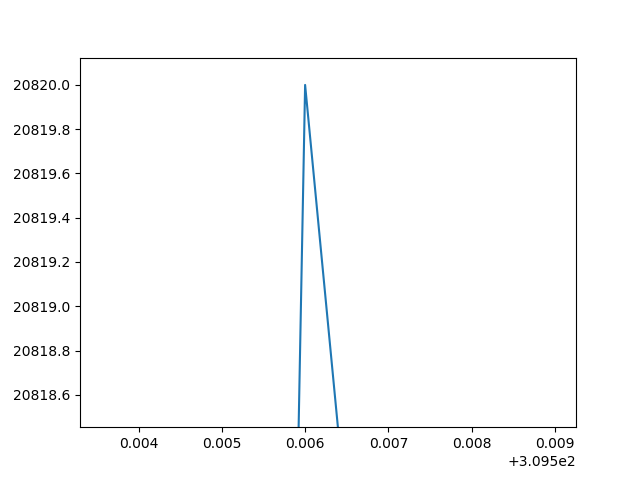

In [45]:
%matplotlib notebook
plt.plot(wl, data[20,:])
plt.show()

(1446, 1)
[4810.33045478]


<IPython.core.display.Javascript object>


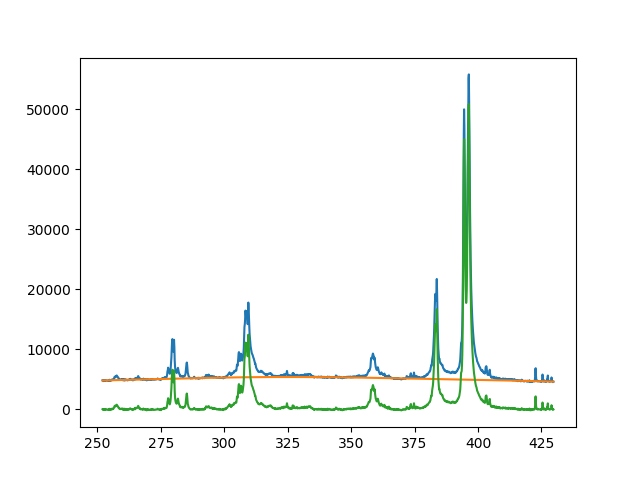

In [21]:
orig= data[0,:]

corrected, x1= drPLS(wl, orig, lam= 10e7) #lambda

print(x1.shape)
print(x1[0])

%matplotlib notebook
plt.plot(wl, orig)
plt.plot(wl, x1)
plt.plot(wl, corrected)
plt.show()

(1446, 1)
[4230.06419893]


<IPython.core.display.Javascript object>


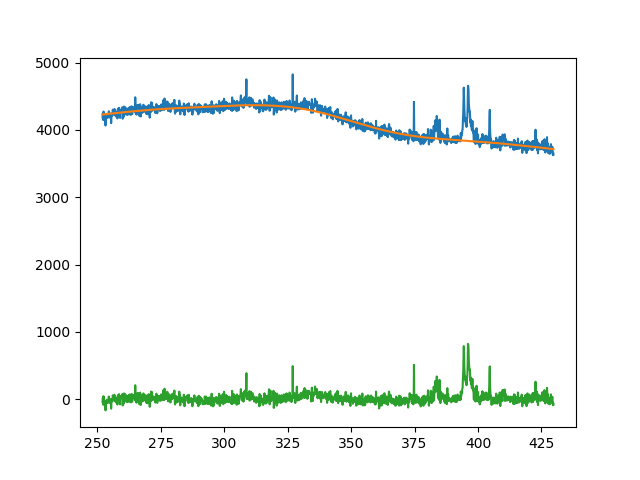

In [22]:
orig= data[1,:]

corrected, x1= drPLS(wl, orig, lam= 10e7)

print(x1.shape)
print(x1[0])

%matplotlib notebook
plt.plot(wl, orig)
plt.plot(wl, x1)
plt.plot(wl, corrected)
plt.show()

In [25]:
## THIS IS THE COMPLETE LOOP FOR DATA MANIPULATION

p=0.001
lam= 10000


print("the wavelength used for intensity filtering is: ", wl[445])

tot= np.empty((0, len(wl.T)))
print(tot.shape)




for j in range(0, len(dfs)): #loop over all .mat files
    data = dfs[j].values
    data = data[1:,:] #this eliminates wavelengths
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl.T)))
    
    for i in (range(len(data)) ):
        
        orig= data[i,:]
        
        #if ((max(orig)) < 65500):
        #if ((max(orig)) < 65500) and ((max(orig)) > 25500):
            
        corrected, x1= drPLS(wl, orig, lam= 10e7)

        if max(corrected) > 20000:
            count += 1

            corrected= normalize(corrected.reshape(1, -1))
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, corrected.reshape(1, -1), axis=0)

            #print("a:", a.shape)
            #print("tmp:", tmp.shape)

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

(0, 1446)
data index: 0
data 0 shape:  (100, 1446)
good spectra:  74
tmp shape:  (74, 1446)
avg array shape:  (1, 1446)

data index: 1
data 1 shape:  (51, 1446)
good spectra:  26
tmp shape:  (26, 1446)
avg array shape:  (1, 1446)

data index: 2
data 2 shape:  (35, 1446)
good spectra:  32
tmp shape:  (32, 1446)
avg array shape:  (1, 1446)

data index: 3
data 3 shape:  (46, 1446)
good spectra:  35
tmp shape:  (35, 1446)
avg array shape:  (1, 1446)

data index: 4
data 4 shape:  (28, 1446)
good spectra:  24
tmp shape:  (24, 1446)
avg array shape:  (1, 1446)

data index: 5
data 5 shape:  (40, 1446)
good spectra:  40
tmp shape:  (40, 1446)
avg array shape:  (1, 1446)

data index: 6
data 6 shape:  (66, 1446)
good spectra:  16
tmp shape:  (16, 1446)
avg array shape:  (1, 1446)

data index: 7
data 7 shape:  (32, 1446)
good spectra:  20
tmp shape:  (20, 1446)
avg array shape:  (1, 1446)

data index: 8
data 8 shape:  (34, 1446)
good spectra:  27
tmp shape:  (27, 1446)
avg array shape:  (1, 1446)


In [46]:
## THIS IS THE COMPLETE LOOP FOR DATA MANIPULATION

p=0.001
lam= 10000


print("the wavelength used for intensity filtering is: ", wl[445])

tot= np.empty((0, len(wl.T)))
print(tot.shape)

for j in range(0, len(dfs)): #loop over all .mat files
    data = dfs[j].values
    data = data[1:,:] #this eliminates wavelengths
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl.T)))
    
    for i in (range(len(data)) ):
        
        orig= data[i,:]
        
        #if ((max(orig)) < 65500):
        #if ((max(orig)) < 65500) and ((max(orig)) > 25500):
            
        corrected, x1= drPLS(wl, orig, lam= 10e7)

        if corrected[445] > 6000:
            count += 1

            corrected= normalize(corrected.reshape(1, -1))
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, corrected.reshape(1, -1), axis=0)

            #print("a:", a.shape)
            #print("tmp:", tmp.shape)

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

the wavelength used for intensity filtering is:  309.506
(0, 1446)
data index: 0
data 0 shape:  (100, 1446)
good spectra:  74
tmp shape:  (74, 1446)
avg array shape:  (1, 1446)

data index: 1
data 1 shape:  (51, 1446)
good spectra:  20
tmp shape:  (20, 1446)
avg array shape:  (1, 1446)

data index: 2
data 2 shape:  (35, 1446)
good spectra:  30
tmp shape:  (30, 1446)
avg array shape:  (1, 1446)

data index: 3
data 3 shape:  (46, 1446)
good spectra:  29
tmp shape:  (29, 1446)
avg array shape:  (1, 1446)

data index: 4
data 4 shape:  (28, 1446)
good spectra:  24
tmp shape:  (24, 1446)
avg array shape:  (1, 1446)

data index: 5
data 5 shape:  (40, 1446)
good spectra:  40
tmp shape:  (40, 1446)
avg array shape:  (1, 1446)

data index: 6
data 6 shape:  (66, 1446)
good spectra:  8
tmp shape:  (8, 1446)
avg array shape:  (1, 1446)

data index: 7
data 7 shape:  (32, 1446)
good spectra:  20
tmp shape:  (20, 1446)
avg array shape:  (1, 1446)

data index: 8
data 8 shape:  (34, 1446)
good spectra: 

In [49]:
## THIS IS THE COMPLETE LOOP FOR DATA MANIPULATION

p=0.001
lam= 10000


print("the wavelength used for intensity filtering is: ", wl[445])

tot= np.empty((0, len(wl.T)))
print(tot.shape)

for j in range(0, len(dfs)): #loop over all .mat files
    data = dfs[j].values
    data = data[1:,:] #this eliminates wavelengths
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl.T)))
    
    for i in (range(len(data)) ):
        
        orig= data[i,:]
        
        #if ((max(orig)) < 65500):
        #if ((max(orig)) < 65500) and ((max(orig)) > 25500):
            
        corrected, x1= drPLS(wl, orig, lam= 10e7)

        if corrected[445] > 6000 and (max(orig)) < 65500:
            count += 1

            corrected = normalize(corrected.reshape(1, -1))
            #print(i)
            #plt.plot(wl, corrected)
            #plt.show()
            tmp = np.append(tmp, corrected.reshape(1, -1), axis=0)

            #print("a:", a.shape)
            #print("tmp:", tmp.shape)

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

the wavelength used for intensity filtering is:  309.506
(0, 1446)
data index: 0
data 0 shape:  (100, 1446)
good spectra:  28
tmp shape:  (28, 1446)
avg array shape:  (1, 1446)

data index: 1
data 1 shape:  (51, 1446)
good spectra:  18
tmp shape:  (18, 1446)
avg array shape:  (1, 1446)

data index: 2
data 2 shape:  (35, 1446)
good spectra:  26
tmp shape:  (26, 1446)
avg array shape:  (1, 1446)

data index: 3
data 3 shape:  (46, 1446)
good spectra:  27
tmp shape:  (27, 1446)
avg array shape:  (1, 1446)

data index: 4
data 4 shape:  (28, 1446)
good spectra:  18
tmp shape:  (18, 1446)
avg array shape:  (1, 1446)

data index: 5
data 5 shape:  (40, 1446)
good spectra:  30
tmp shape:  (30, 1446)
avg array shape:  (1, 1446)

data index: 6
data 6 shape:  (66, 1446)
good spectra:  8
tmp shape:  (8, 1446)
avg array shape:  (1, 1446)

data index: 7
data 7 shape:  (32, 1446)
good spectra:  18
tmp shape:  (18, 1446)
avg array shape:  (1, 1446)

data index: 8
data 8 shape:  (34, 1446)
good spectra: 

<IPython.core.display.Javascript object>


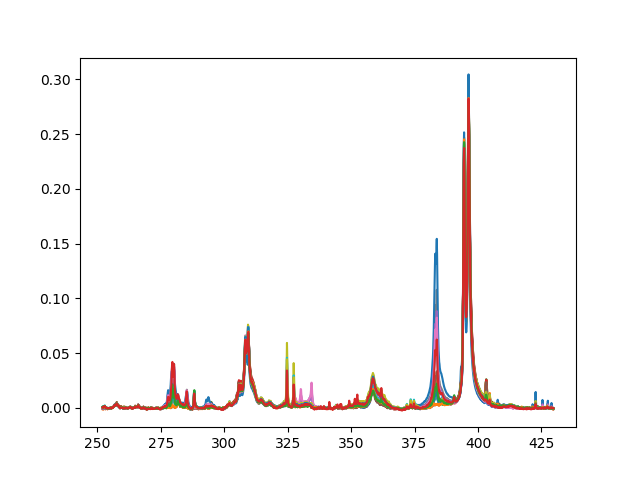

In [50]:
%matplotlib notebook
#%matplotlib inline

for i in range(len(tot)):
    #print(i)
    plt.plot(wl.T, tot[i])
    plt.show()

In [51]:
print(wl.shape)
wl1= wl.reshape(1,-1)
print(tot.shape)

a= np.append(wl1, tot, axis=0)
print(a.shape)
print(a)

np.savetxt("avg_base_norm_wl_sat.csv", a, delimiter=",", fmt='%f')

(1446,)
(24, 1446)
(25, 1446)
[[ 2.52071400e+02  2.52201700e+02  2.52331900e+02 ...  4.29491000e+02
   4.29601300e+02  4.29711600e+02]
 [-1.20212782e-04 -1.41136202e-04 -4.75870175e-04 ... -5.39638353e-04
  -5.87873998e-04 -4.33741195e-04]
 [-1.10992593e-03 -1.06656962e-03 -1.60557999e-03 ... -1.30106476e-03
  -1.64366791e-03 -1.39304496e-03]
 ...
 [ 4.48621839e-04  2.58231107e-05 -2.96068351e-04 ... -7.35364776e-04
  -8.63220471e-04 -7.36834883e-04]
 [ 9.71161270e-04  5.13750359e-04  1.41692118e-04 ... -5.43366369e-04
  -6.83062785e-04 -5.87724329e-04]
 [ 5.39645814e-04  2.06734474e-04  5.24817423e-05 ... -1.42714022e-04
  -3.50176773e-04 -2.08113213e-04]]


In [42]:
wl[445]

309.506

In [10]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

(100, 1446)


<IPython.core.display.Javascript object>


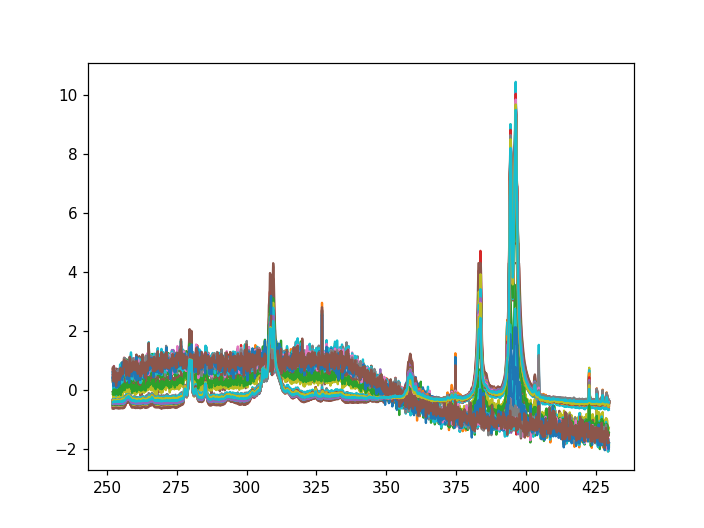

In [11]:
tmp=snv(data)
print(tmp.shape)

%matplotlib notebook
for i in range(len(tmp)):
    plt.plot(wl, tmp[i,:])
    plt.show()

(1, 1446)


<IPython.core.display.Javascript object>


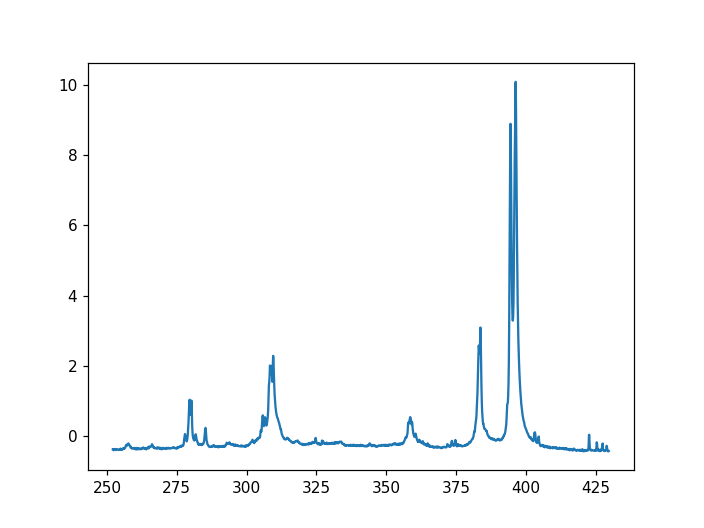

In [12]:
tmp=snv(data[0,:].reshape(1,-1))
print(tmp.shape)

%matplotlib notebook
plt.plot(wl, tmp[0,:])
plt.show()

<IPython.core.display.Javascript object>


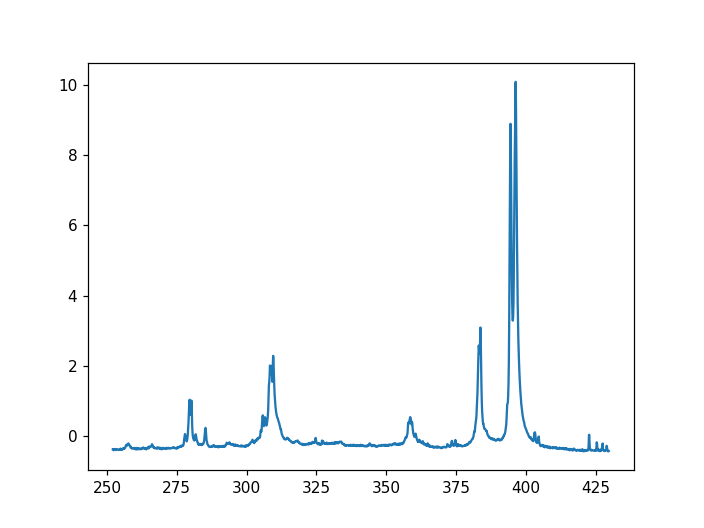

In [13]:
tmp=StandardScaler().fit_transform(data[0,:].reshape(1, -1).T)

%matplotlib notebook
plt.plot(wl, tmp.reshape(-1, 1))
plt.show()

(1446,)
(100, 1446)


<IPython.core.display.Javascript object>


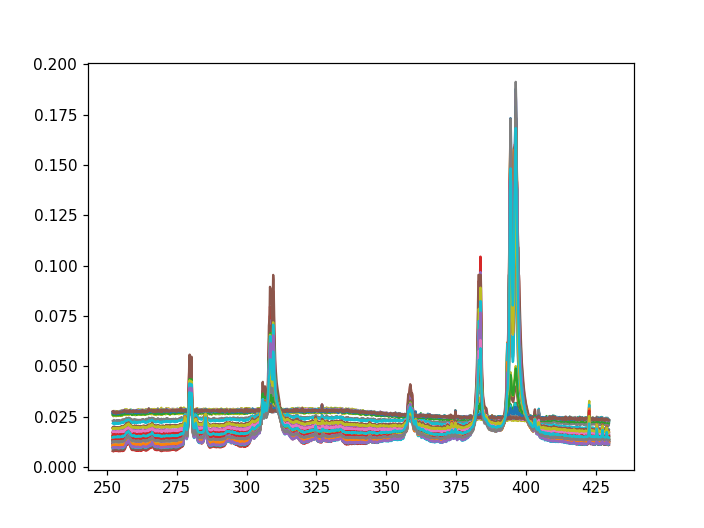

In [14]:
tmp=normalize(data)
print(wl.shape)
print(tmp.shape)



%matplotlib notebook
for i in range(len(tmp)):
    plt.plot(wl, tmp[i,:])
    plt.show()

### Wavelet transform

In [9]:
import pywt
import pywt.data
#print(pywt.families(short=False))
print(pywt.families(short=True), "\n")
#print(pywt.wavelist(kind='discrete'))

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'] 



<IPython.core.display.Javascript object>


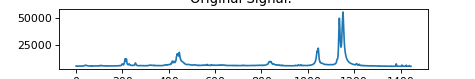

<IPython.core.display.Javascript object>


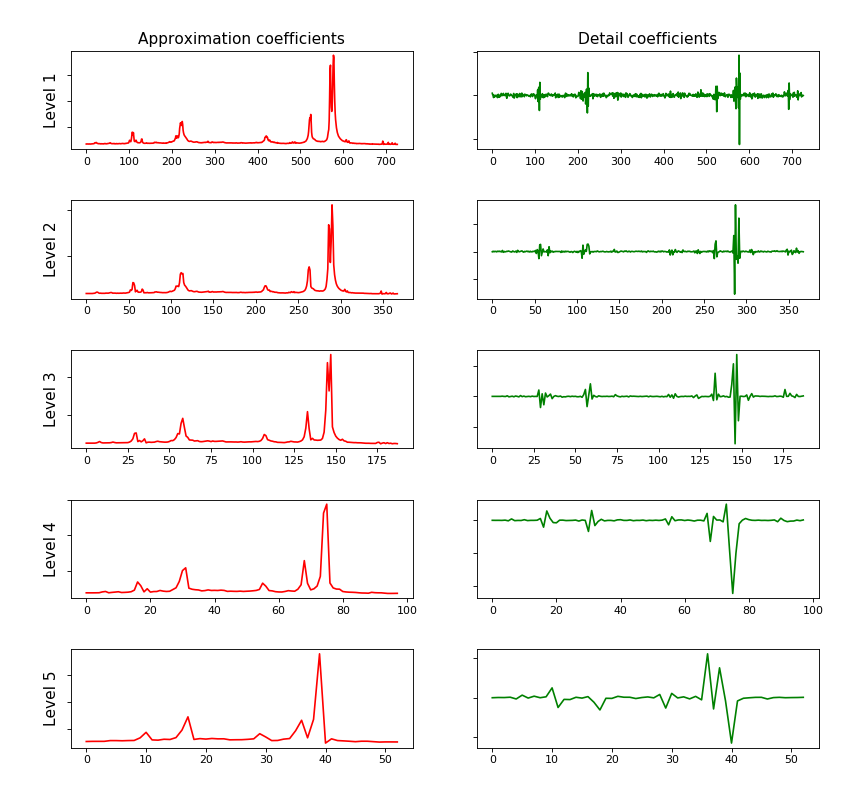

In [10]:
    
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Signal: ")
ax.plot(data[0,:])
plt.show()
    
data1 = data[0,:]
waveletname = 'sym5'
 
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data1, coeff_d) = pywt.dwt(data1, waveletname)
    axarr[ii, 0].plot(data1, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

- The DWT return two sets of coefficients; the approximation coefficients and detail coefficients.
- The approximation coefficients represent the output of the low pass filter (averaging filter) of the DWT.
- The detail coefficients represent the output of the high pass filter (difference filter) of the DWT.
- By applying the DWT again on the approximation coefficients of the previous DWT, we get the wavelet transform of the next level.
- At each next level, the original signal is also sampled down by a factor of 2.

<IPython.core.display.Javascript object>


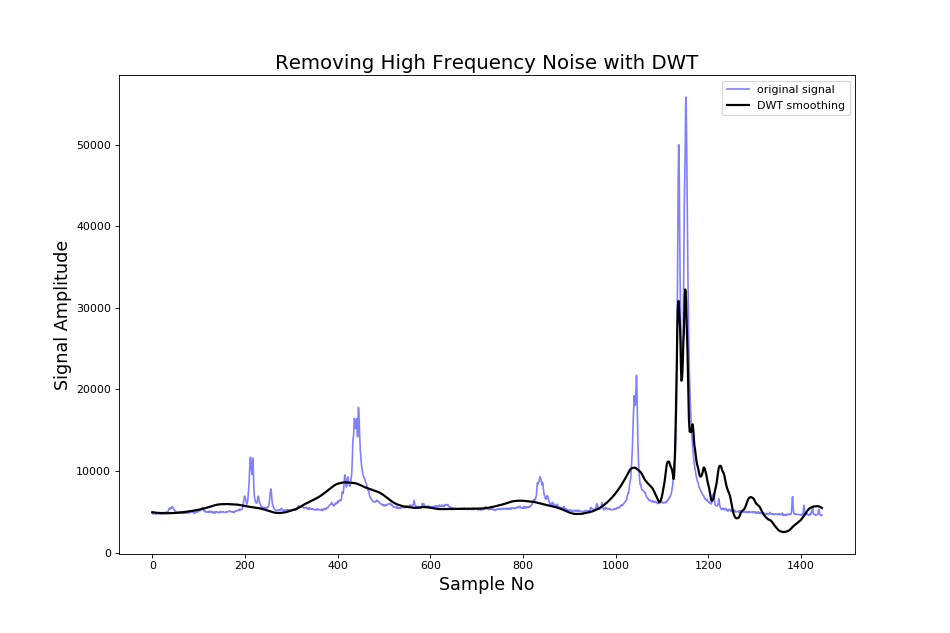

In [12]:
#Is this even useful???

signal = data[0,:]

def lowpassfilter(signal, thresh = 0.63, wavelet="coif9"):
#def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="sp1" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="sp1" )
    return reconstructed_signal
 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(signal, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(signal, 0.4)
ax.plot(rec, 'k', label='DWT smoothing', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

# Normalization

In [16]:
data[0,:]

array([4834., 4823., 4700., ..., 4533., 4572., 4599.])

In [17]:
a= normalize(data[0,:].reshape(1, -1))
a.shape

(1, 1446)

In [18]:
print(wl.shape)
print(a.shape)

(1446,)
(1, 1446)


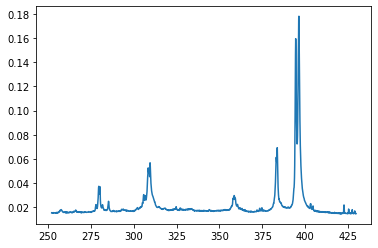

In [21]:
%matplotlib inline
plt.plot(wl, a.T)
plt.show()

(1446,)
(100, 1446)


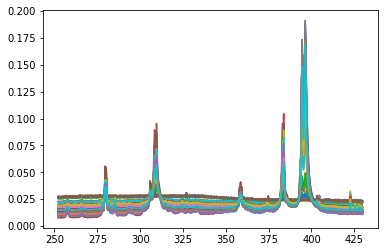

In [23]:
tmp=normalize(data)
print(wl.shape)
print(tmp.shape)


%matplotlib inline
for i in range(len(tmp)):
    plt.plot(wl, tmp[i,:])
    #plt.show()

In [24]:
print(wl.shape)
print(len(wl))

(1446,)
1446


In [52]:
## THIS IS THE COMPLETE LOOP FOR DATA MANIPULATION

p=0.001
lam= 10000

tot= np.empty((0, len(wl.T)))
print(tot.shape)


for j in range(0, len(dfs)): #loop over all .mat files
    data = dfs[j].values
    data = data[1:,:] #this eliminates wavelengths
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl.T)))
    
    for i in (range(len(data)) ):
        
        #if ((max(data[i,:])) < 65500):
        if ((max(data[i,:])) < 65500) and ((max(data[i,:])) > 25500):
            
            #z_i = baseline_als(data[i,:], lam, p, niter=10)

            a = data[i,:] #without baseline correction
            #a = data[i,:] - z_i
            
            if max(a) > 25000:
                count += 1
                
                a= normalize(data[i,:].reshape(1, -1))
                #print(i)
                #plt.plot(wl, data[:,i])
                #plt.show()
                tmp = np.append(tmp, a.reshape(1, -1), axis=0)
                
                #print("a:", a.shape)
                #print("tmp:", tmp.shape)

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    #avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

(0, 1446)
data index: 0
data 0 shape:  (100, 1446)
good spectra:  28
tmp shape:  (28, 1446)
avg array shape:  (1, 1446)

data index: 1
data 1 shape:  (51, 1446)
good spectra:  23
tmp shape:  (23, 1446)
avg array shape:  (1, 1446)

data index: 2
data 2 shape:  (35, 1446)
good spectra:  29
tmp shape:  (29, 1446)
avg array shape:  (1, 1446)

data index: 3
data 3 shape:  (46, 1446)
good spectra:  32
tmp shape:  (32, 1446)
avg array shape:  (1, 1446)

data index: 4
data 4 shape:  (28, 1446)
good spectra:  18
tmp shape:  (18, 1446)
avg array shape:  (1, 1446)

data index: 5
data 5 shape:  (40, 1446)
good spectra:  30
tmp shape:  (30, 1446)
avg array shape:  (1, 1446)

data index: 6
data 6 shape:  (66, 1446)
good spectra:  17
tmp shape:  (17, 1446)
avg array shape:  (1, 1446)

data index: 7
data 7 shape:  (32, 1446)
good spectra:  18
tmp shape:  (18, 1446)
avg array shape:  (1, 1446)

data index: 8
data 8 shape:  (34, 1446)
good spectra:  15
tmp shape:  (15, 1446)
avg array shape:  (1, 1446)


0


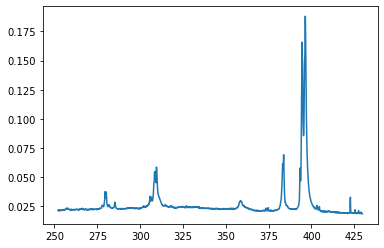

1


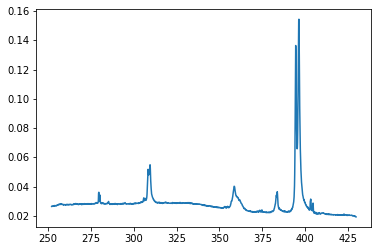

2


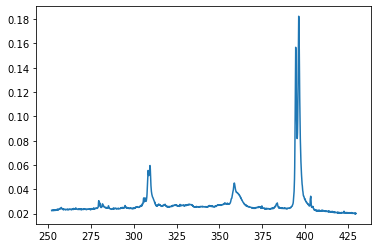

3


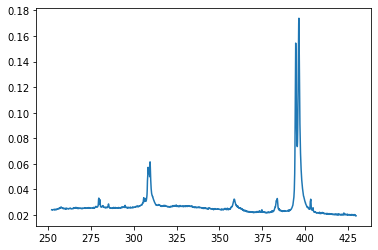

4


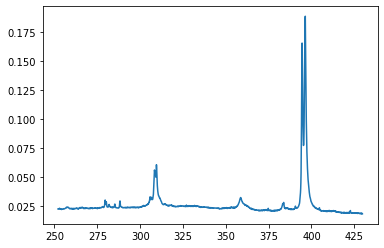

5


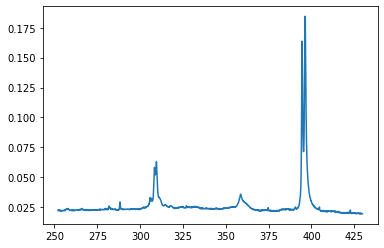

6


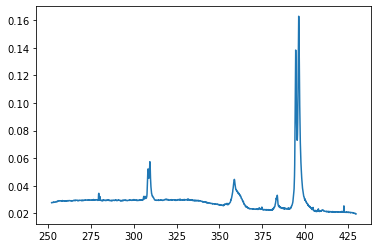

7


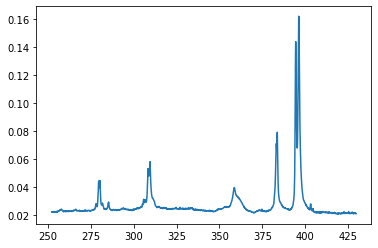

8


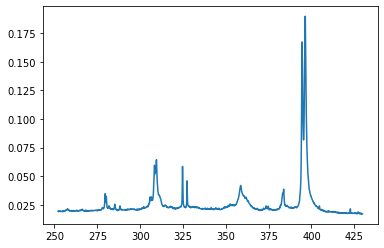

9


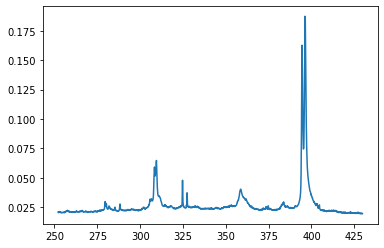

10


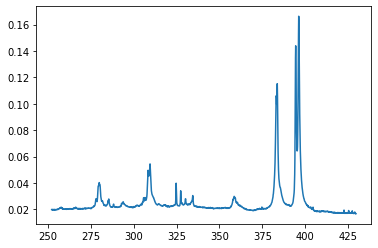

11


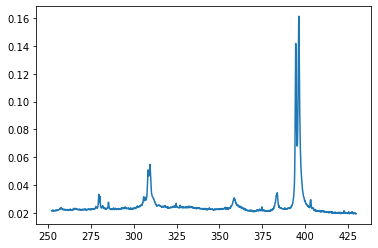

12


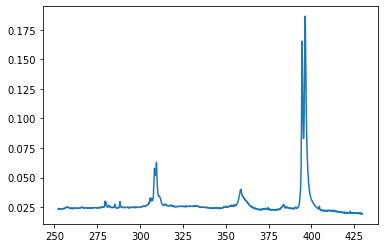

13


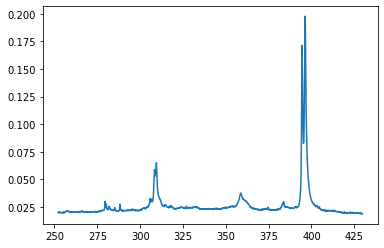

14


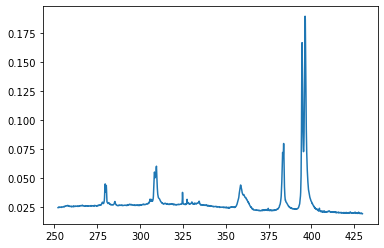

15


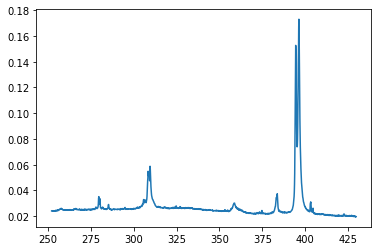

16


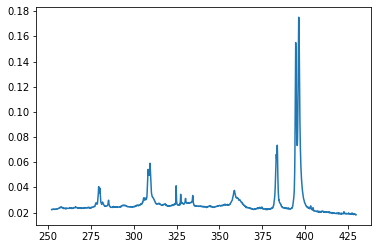

17


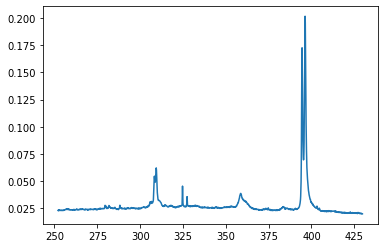

18


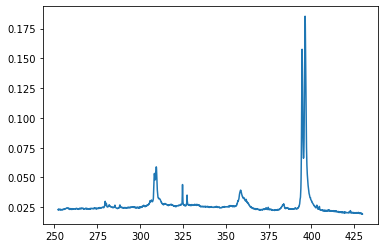

19


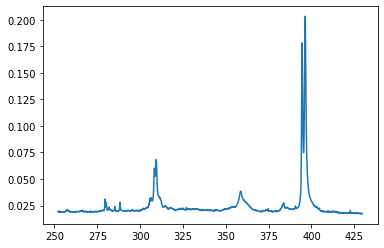

20


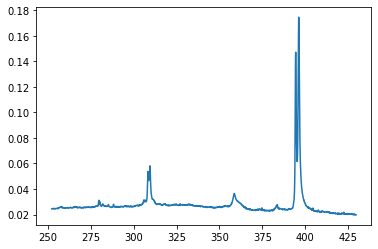

21


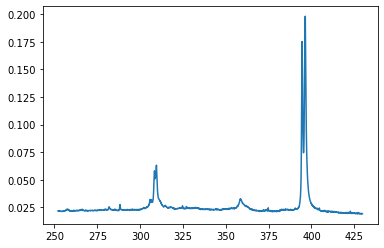

22


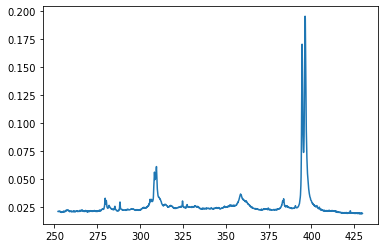

23


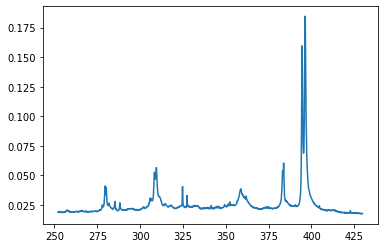

In [53]:
#%matplotlib notebook
%matplotlib inline

for i in range(len(tot)):
    print(i)
    plt.plot(wl.T, tot[i])
    plt.show()

In [54]:
print(wl.shape)
wl= wl.reshape(1,-1)
print(tot.shape)

a= np.append(wl, tot, axis=0)
print(a.shape)
print(a)

np.savetxt("avg_norm.csv", a, delimiter=",", fmt='%f')

(1, 1446)
(24, 1446)
(25, 1446)
[[2.52071400e+02 2.52201700e+02 2.52331900e+02 ... 4.29491000e+02
  4.29601300e+02 4.29711600e+02]
 [2.15873539e-02 2.14408748e-02 2.12907337e-02 ... 1.85332651e-02
  1.86467864e-02 1.86797442e-02]
 [2.63696687e-02 2.66418141e-02 2.65470371e-02 ... 1.92383766e-02
  1.92069248e-02 1.92112575e-02]
 ...
 [2.17524430e-02 2.13906918e-02 2.13260934e-02 ... 1.90059917e-02
  1.90359291e-02 1.91257414e-02]
 [2.07210582e-02 2.06339564e-02 2.07669013e-02 ... 1.87223013e-02
  1.87452228e-02 1.89790223e-02]
 [1.89500508e-02 1.87616270e-02 1.86997164e-02 ... 1.75259172e-02
  1.74585216e-02 1.76637719e-02]]


### First baseline correction (peakutils)

In [13]:
baseline_values = peakutils.baseline( data[0,:])


<IPython.core.display.Javascript object>


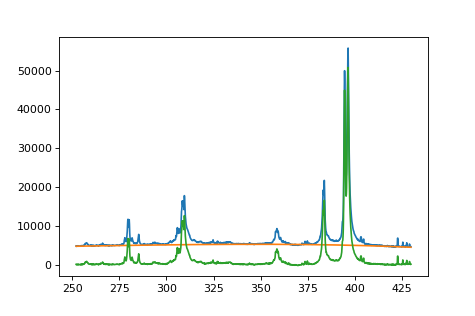

In [19]:
%matplotlib notebook

baseline_values = peakutils.baseline(data[0,:], deg=3)

plt.plot(wl, data[0,:])
plt.plot(wl, baseline_values)

new=data[0,:] - baseline_values
plt.plot(wl, new )

In [19]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

<IPython.core.display.Javascript object>


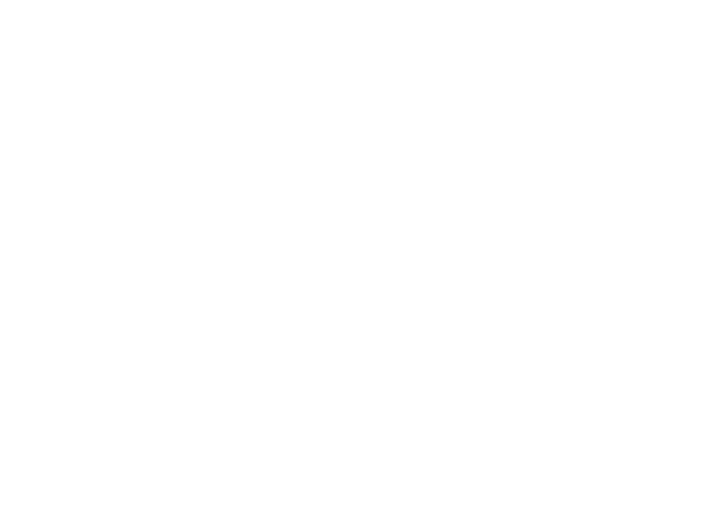

(1446,)
(1, 1446)
(1, 1446) (1, 1446)


In [20]:
x=data[0,:]

%matplotlib notebook
plt.plot(wl, data[0,:])

print(x.shape)
X2 = savgol_filter(x.reshape(1,-1), 13, polyorder = 4,deriv=0) 
print(X2.shape)
X3= msc(x.reshape(1,-1))[0]

print(X2.shape, X3.shape)

#plt.plot(wl, X2.T)
plt.plot(wl, X3.T)


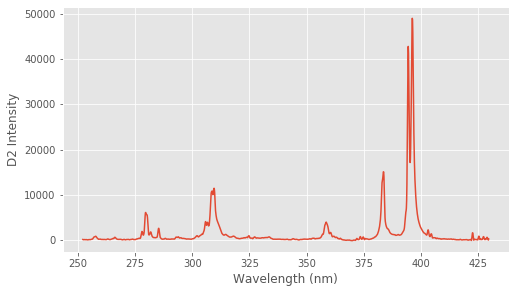

<IPython.core.display.Javascript object>


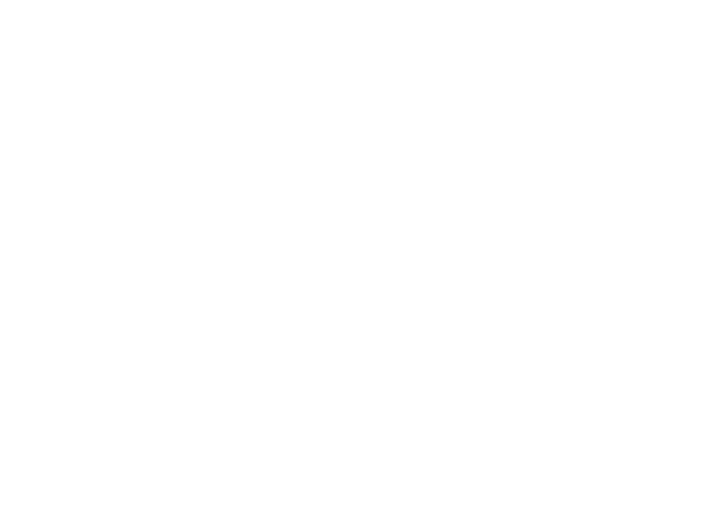

In [21]:
%matplotlib inline
# Calculate second derivative
X2 = savgol_filter(new, 13, polyorder = 4,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    
%matplotlib notebook

plt.plot(wl, new)
plt.plot(wl, X2)
plt.show()
    

<IPython.core.display.Javascript object>


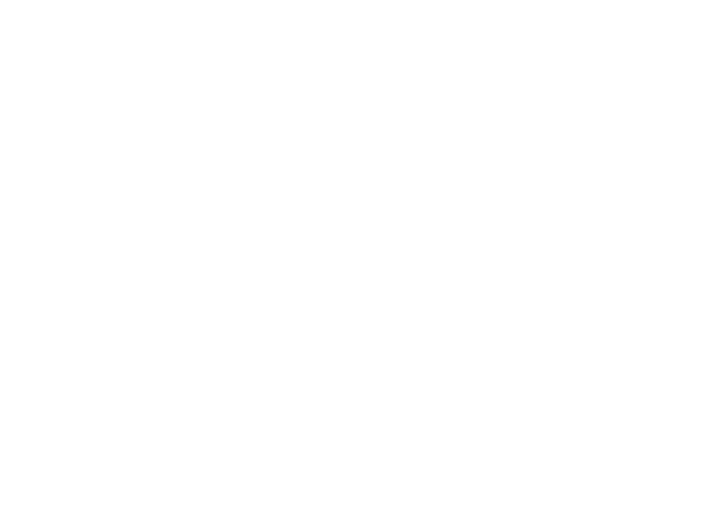

In [22]:
X2 = savgol_filter(new, 13, polyorder = 4,deriv=2)
X3 = savgol_filter(data[0,:], 13, polyorder = 4,deriv=2)


%matplotlib notebook
plt.plot(wl, X2)
plt.plot(wl, X3)




<IPython.core.display.Javascript object>


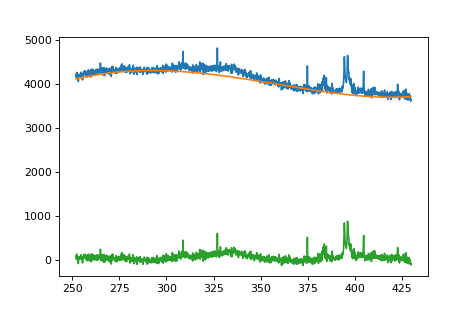

In [20]:
basel = peakutils.baseline(data[1,:], deg =3)

%matplotlib notebook
plt.plot(wl, data[1,:])
plt.plot(wl, basel)
plt.plot(wl, data[1,:]- basel )

<IPython.core.display.Javascript object>


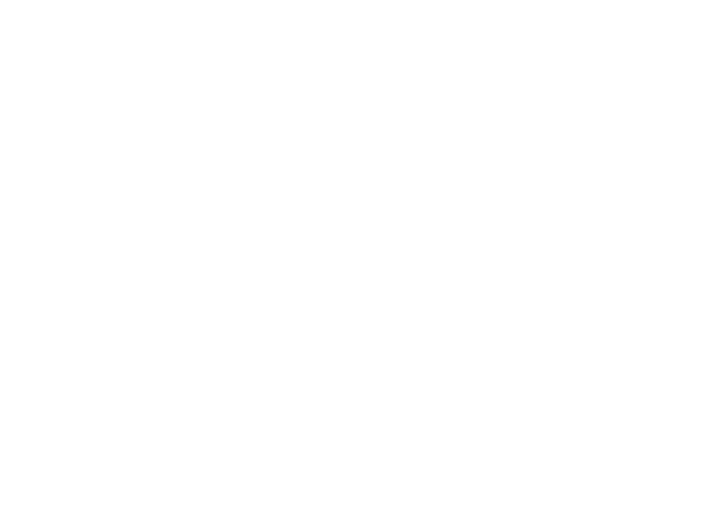

In [24]:
%matplotlib notebook
for i in (range(len(data))):
    
    z_i = peakutils.baseline(data[i,:], deg =3)
    
    tmp= data[i,:] -z_i
    #print(max(tmp))
    
    plt.plot(wl, tmp)
    plt.show()
    

### Second baseline correction (baseline_als)

In [21]:
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

There are two parameters: p for asymmetry and λ for smoothness. Both have to be tuned to the data at hand. We found that generally 0.001 ≤ p ≤ 0.1 is a good choice (for a signal with positive peaks) and 10^2 ≤ λ ≤ 10^9, but exceptions may occur. In any case one should vary λ on a grid that is approximately linear for log λ. Often visual inspection is sufficient to get good parameter values.

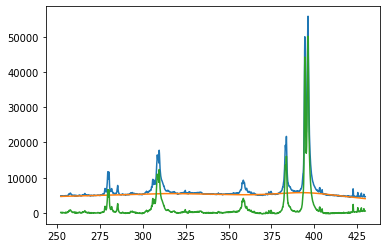

In [44]:
p=0.01
lam= 10000000

z = baseline_als(data[0,:], lam, p, niter=10)

x= data[0,:] -z


%matplotlib inline
plt.plot(wl, data[0,:])
plt.plot(wl, z)
plt.plot(wl,x)

<IPython.core.display.Javascript object>


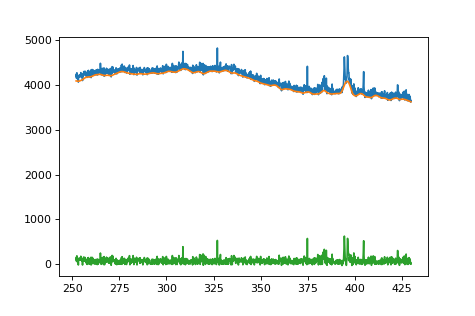

In [24]:
p=0.01
lam= 105

z = baseline_als(data[1,:], lam, p, niter=10)

x= data[1,:] -z


%matplotlib notebook
plt.plot(wl, data[1,:])
plt.plot(wl, z)
plt.plot(wl,x)

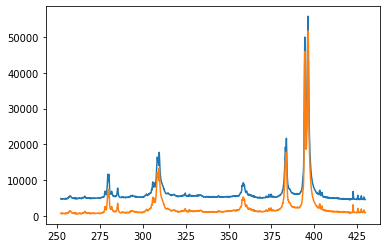

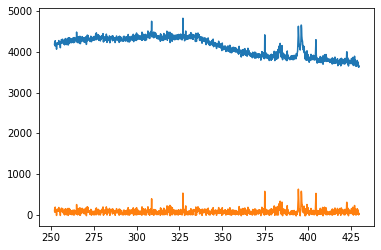

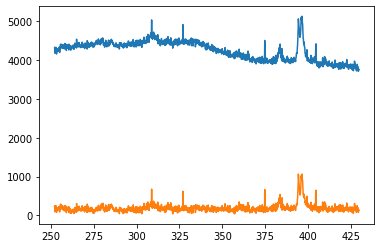

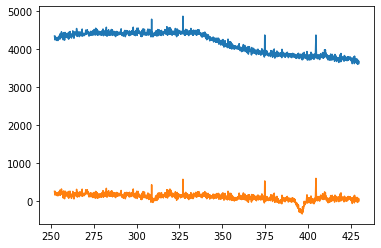

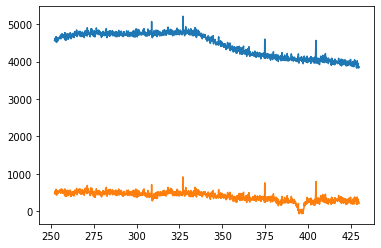

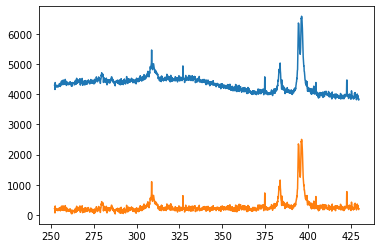

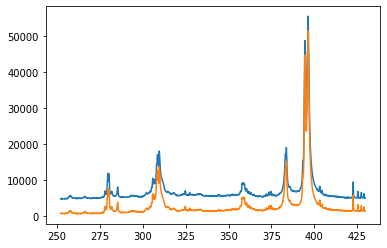

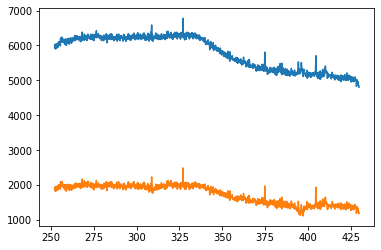

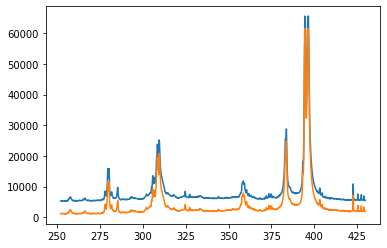

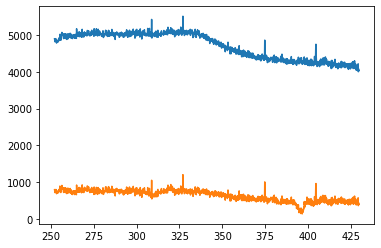

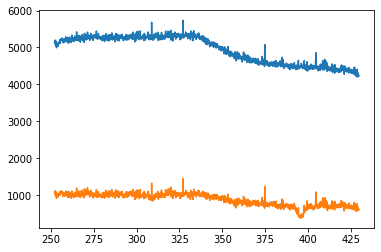

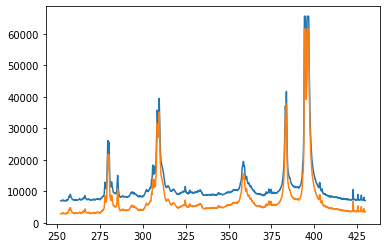

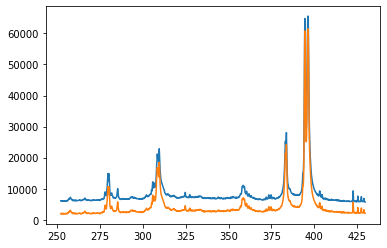

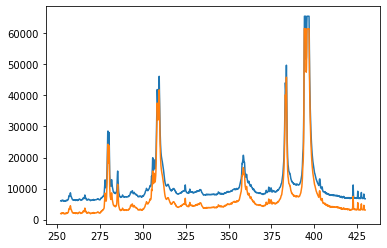

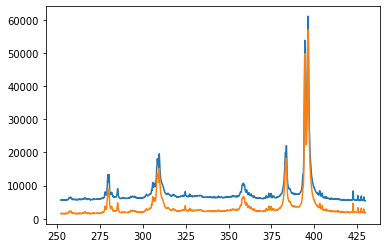

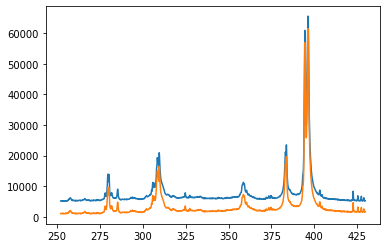

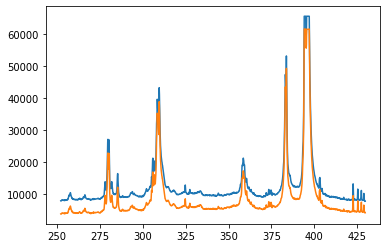

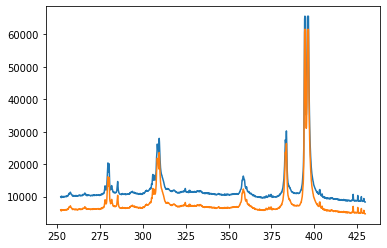

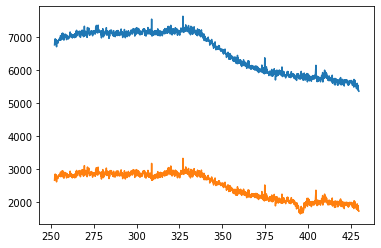

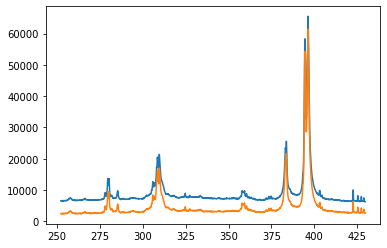

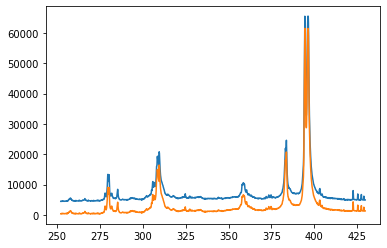

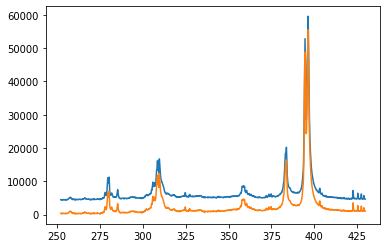

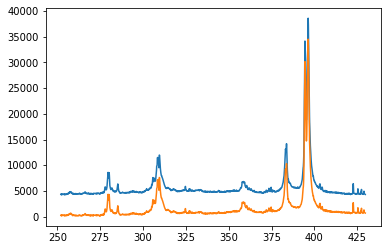

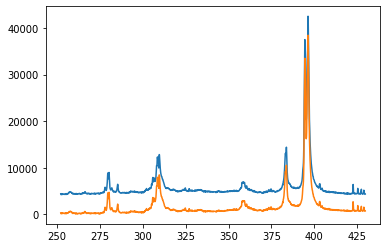

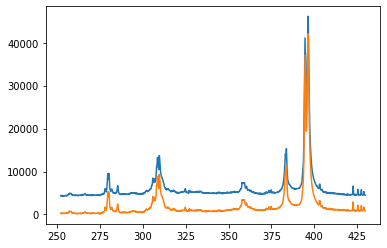

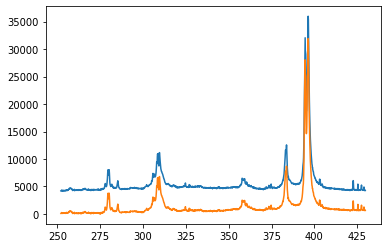

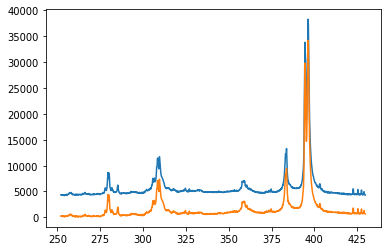

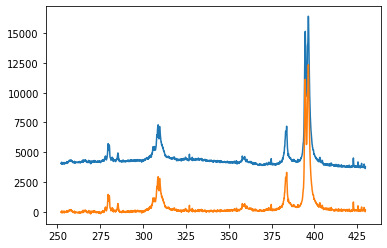

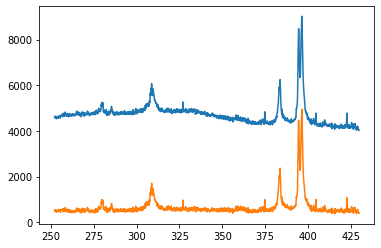

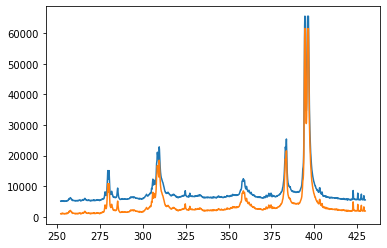

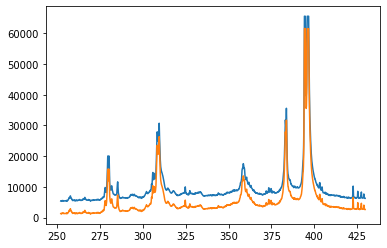

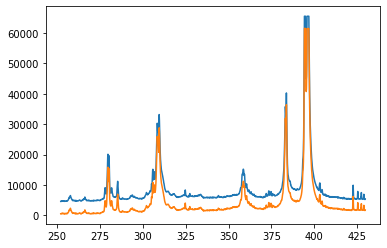

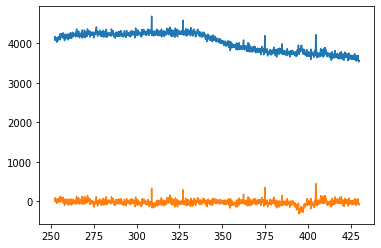

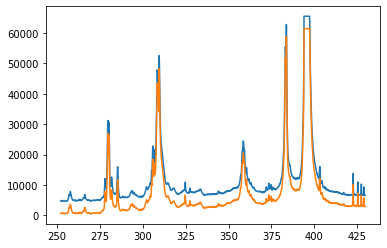

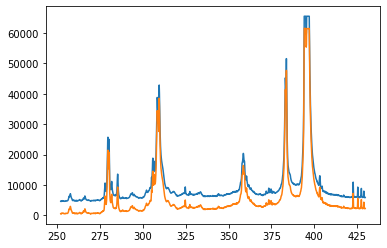

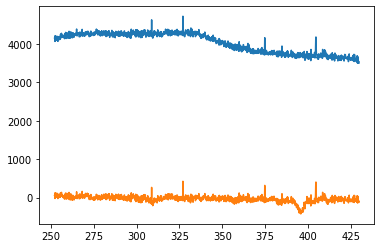

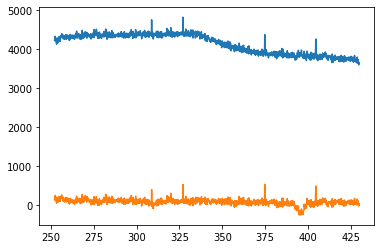

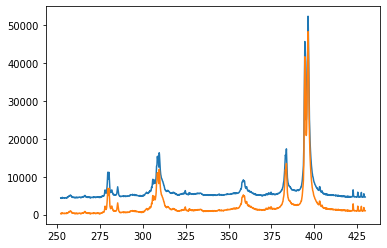

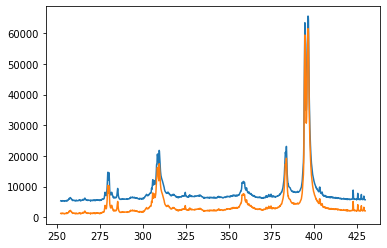

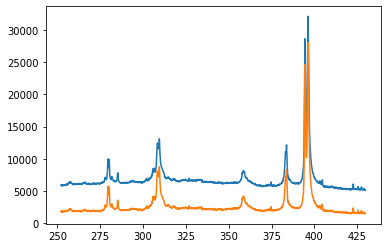

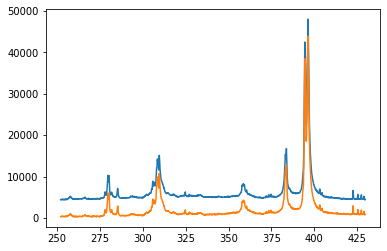

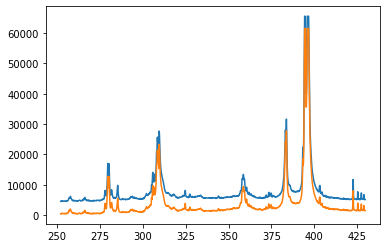

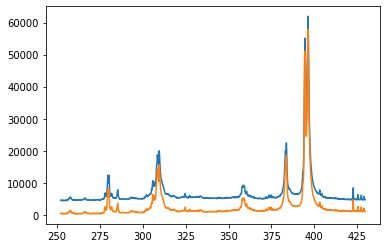

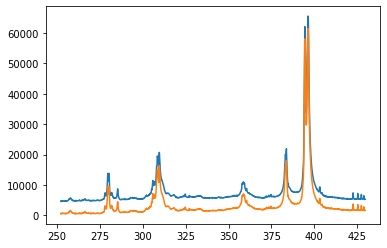

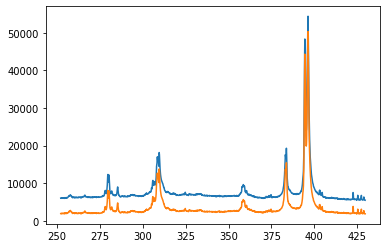

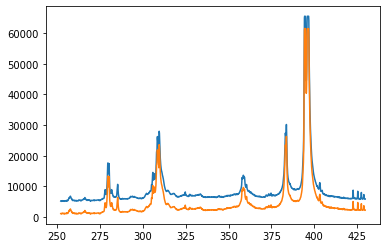

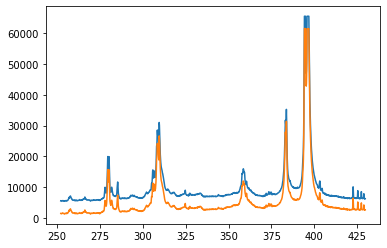

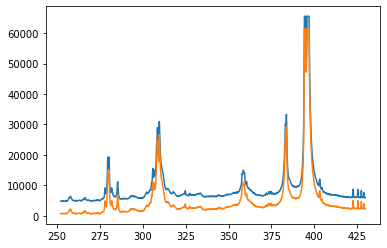

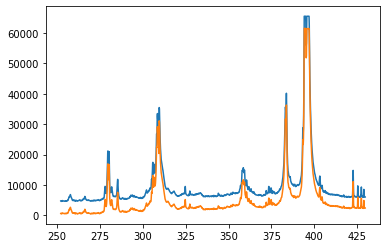

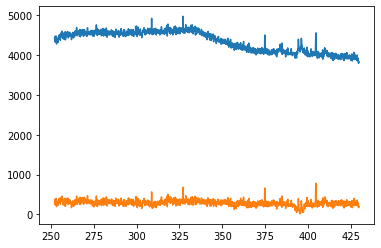

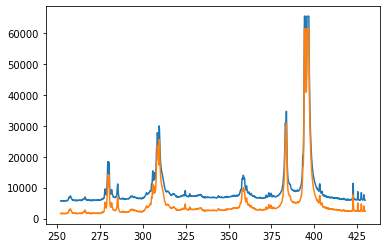

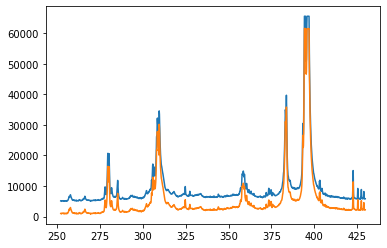

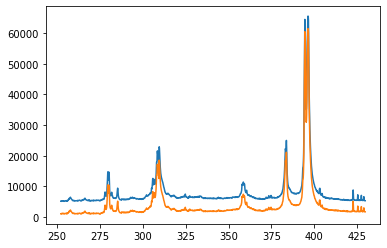

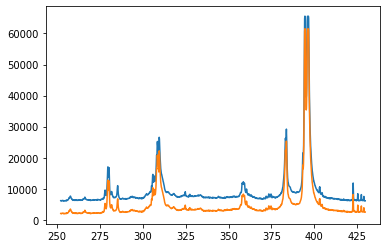

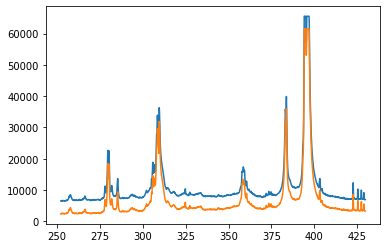

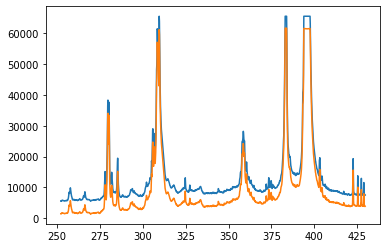

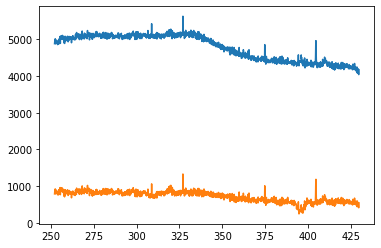

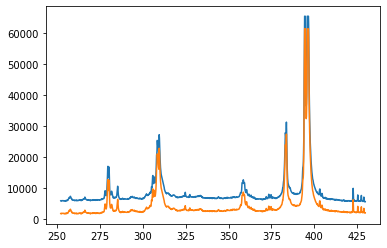

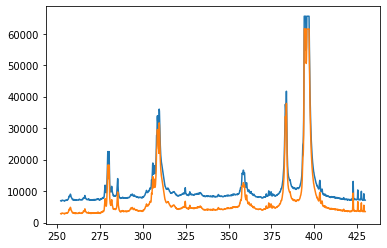

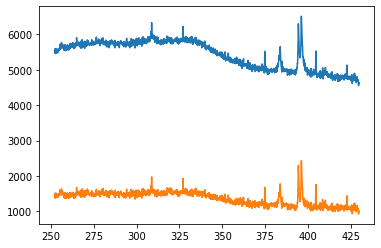

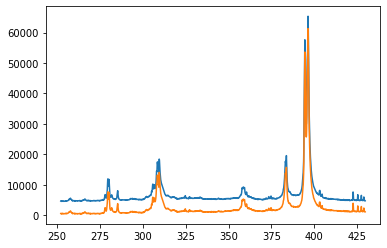

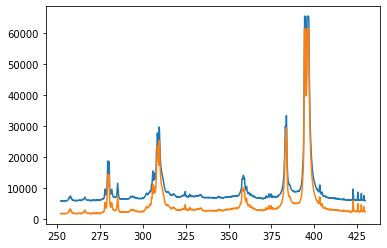

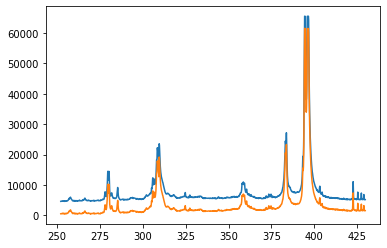

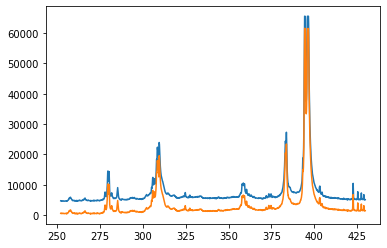

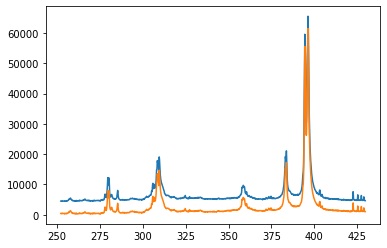

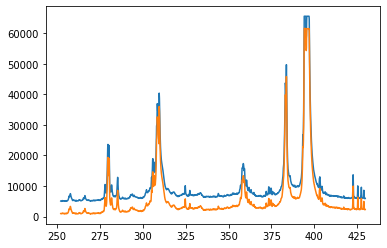

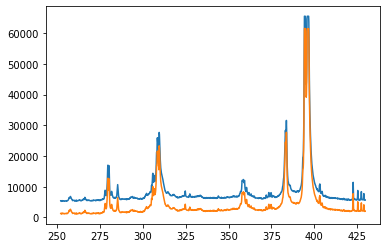

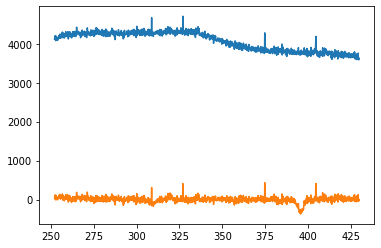

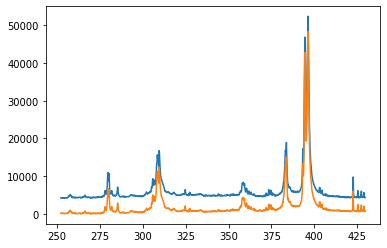

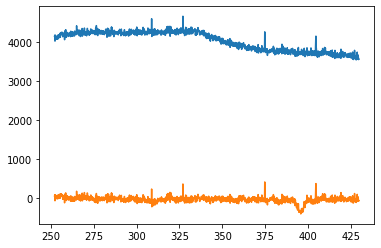

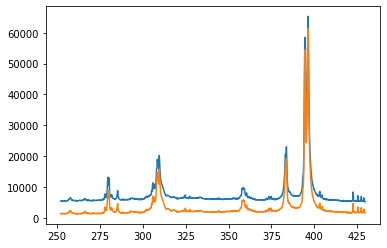

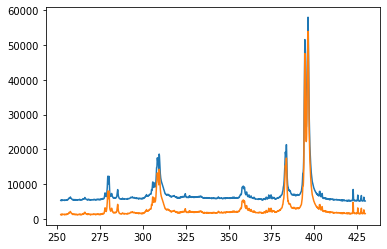

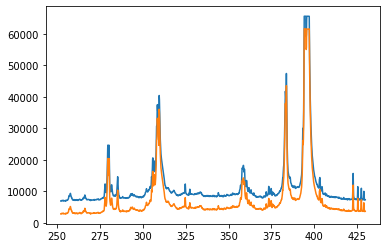

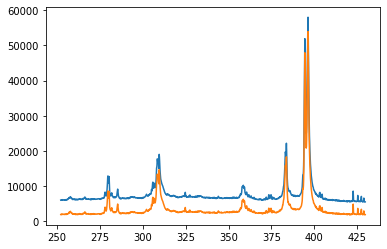

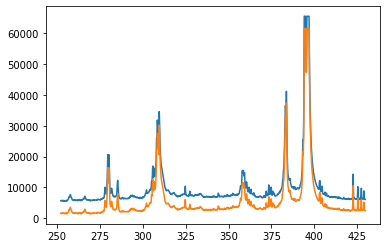

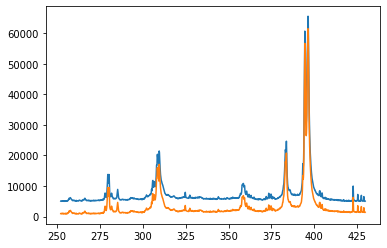

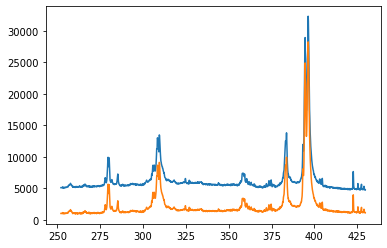

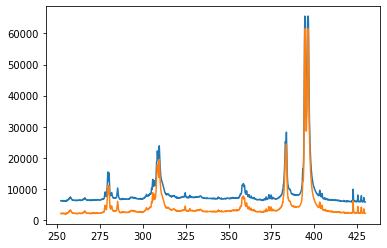

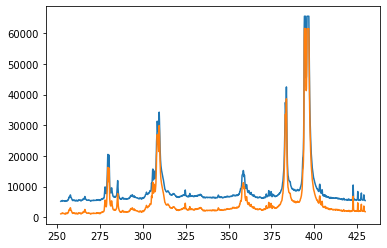

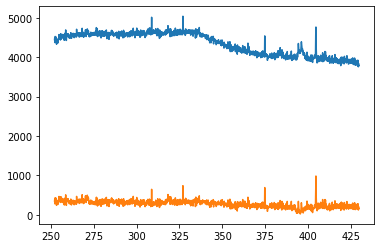

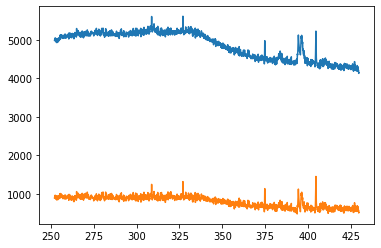

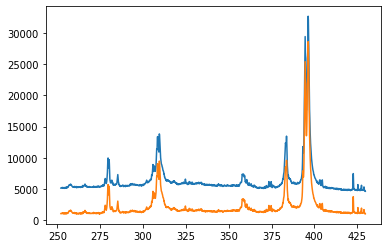

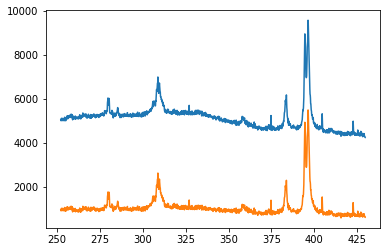

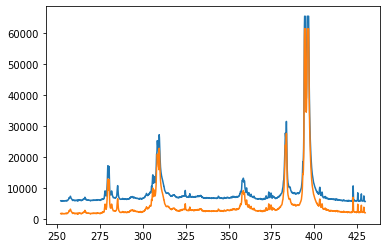

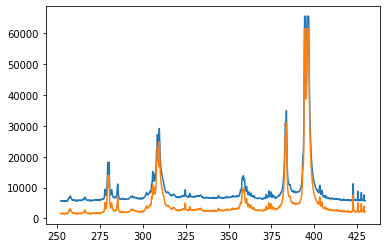

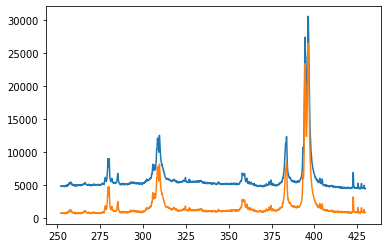

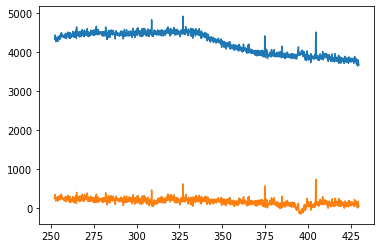

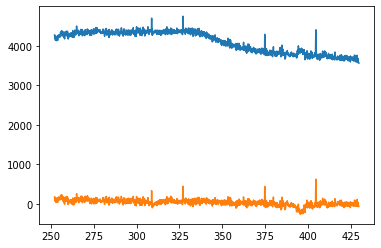

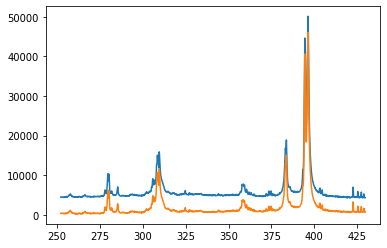

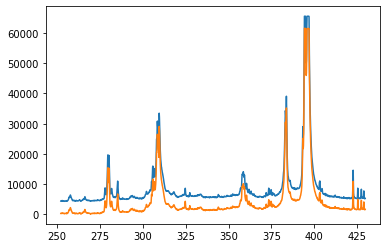

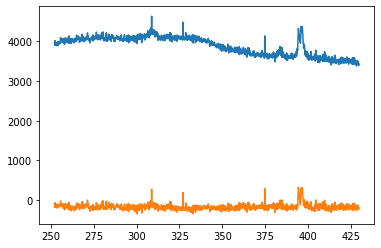

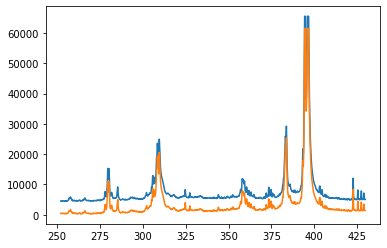

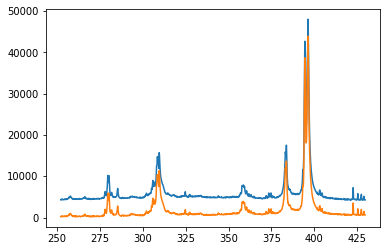

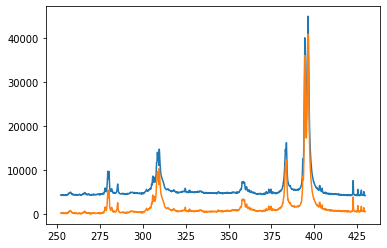

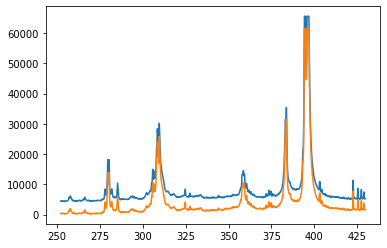

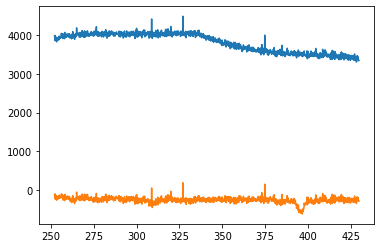

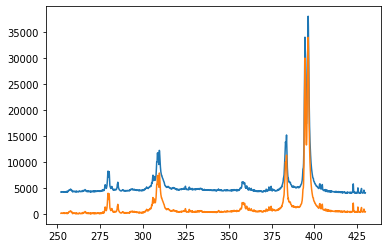

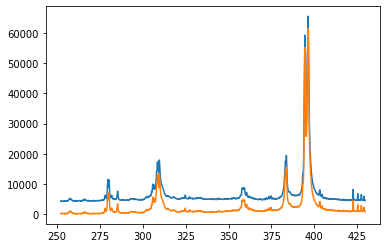

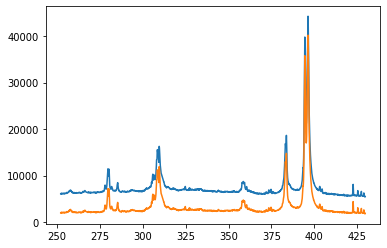

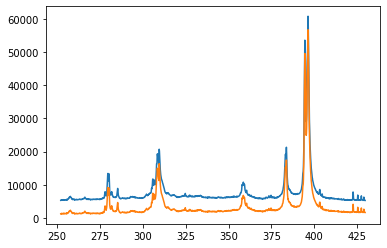

In [31]:
%matplotlib inline
for i in (range(len(data))):
    
    z_i = baseline_als(data[i,:], lam, p, niter=10)
    
    tmp= data[i,:] - z
    #print(max(tmp))
    
    plt.plot(wl, data[i,:])
    plt.plot(wl, tmp)
    plt.show()
    

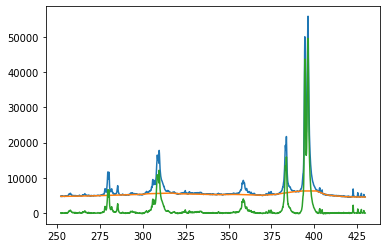

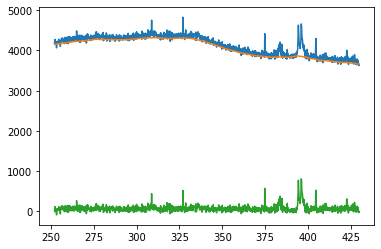

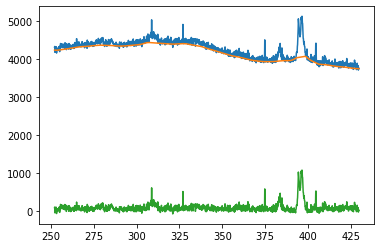

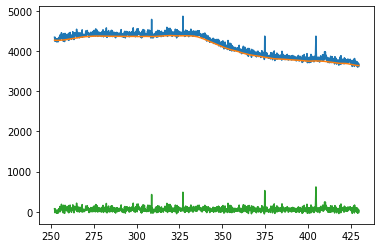

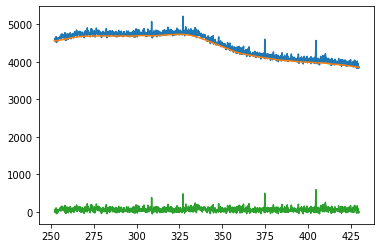

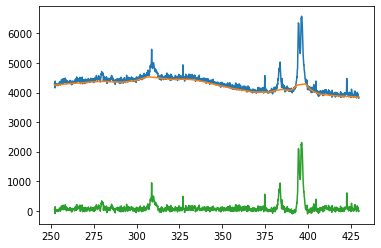

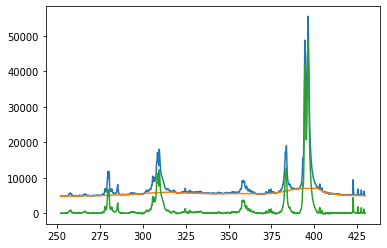

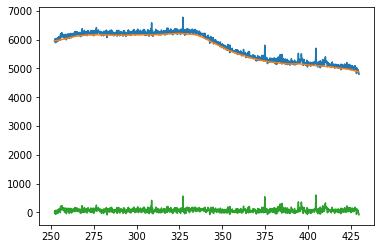

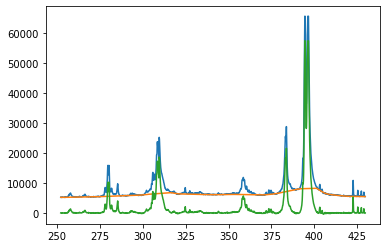

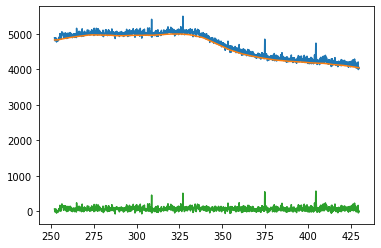

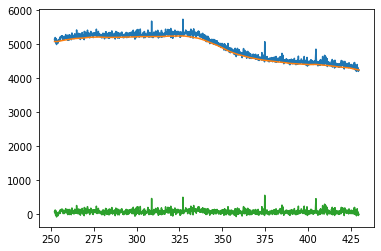

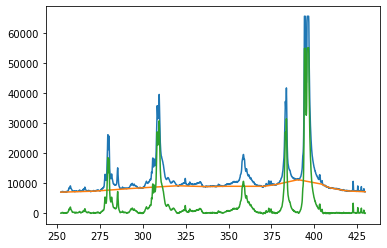

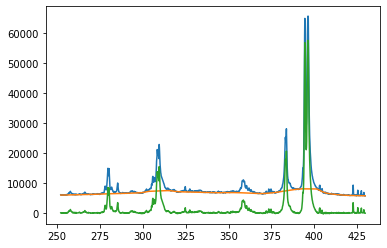

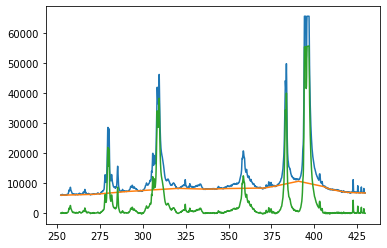

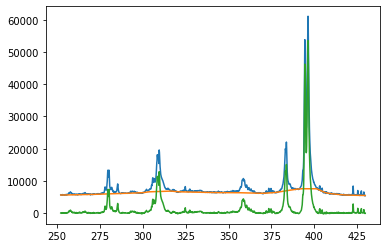

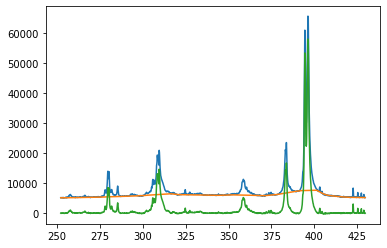

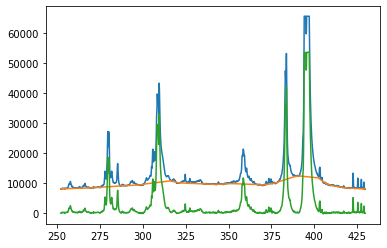

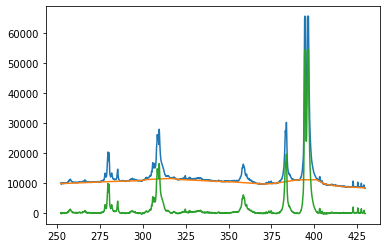

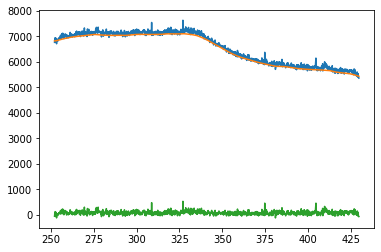

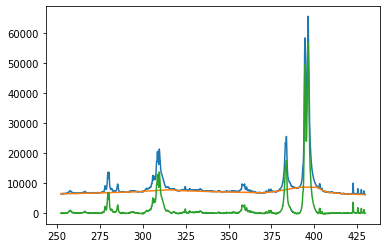

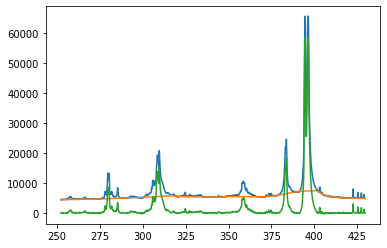

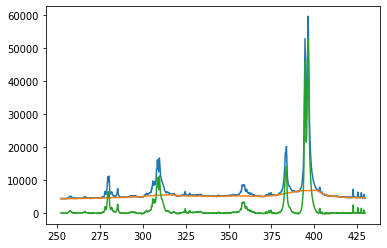

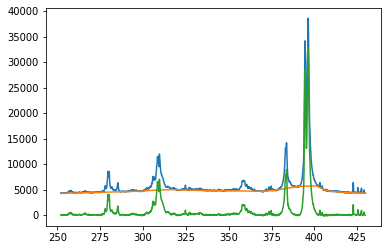

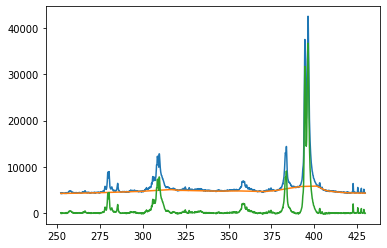

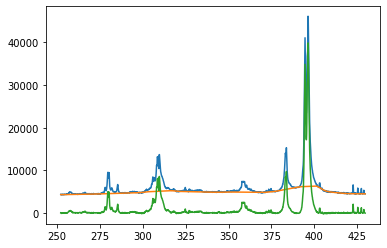

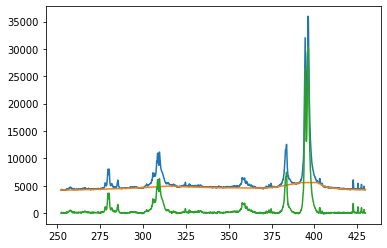

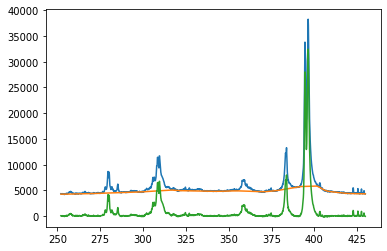

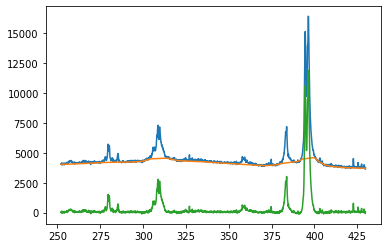

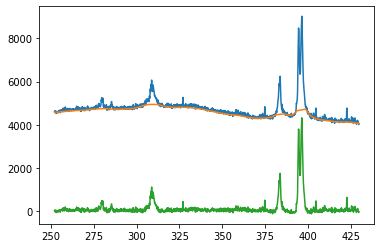

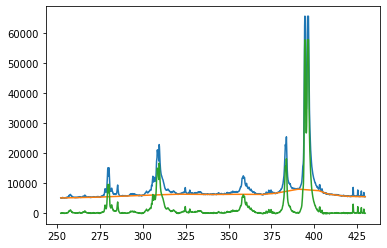

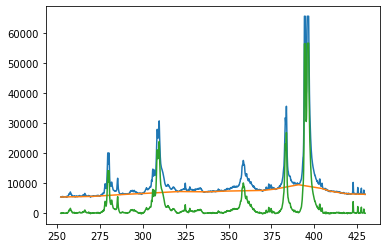

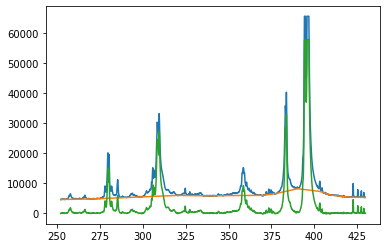

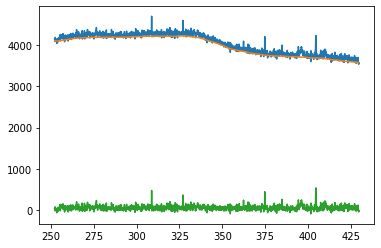

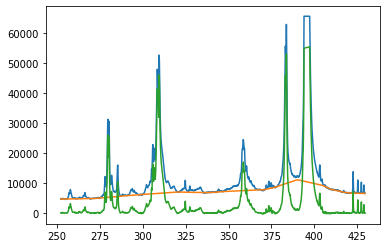

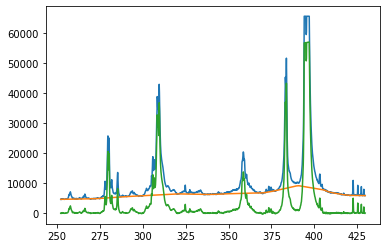

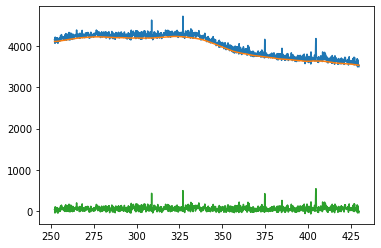

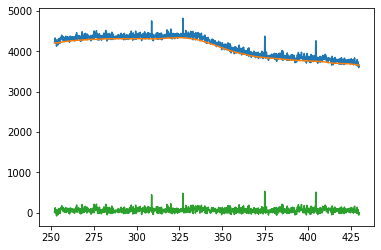

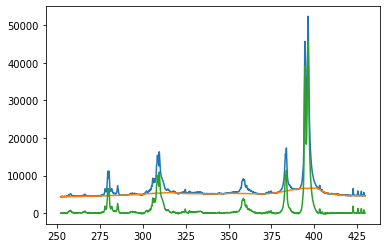

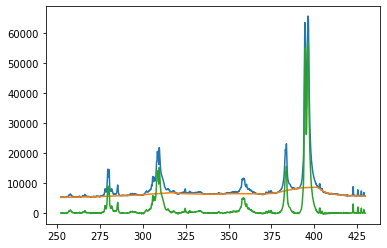

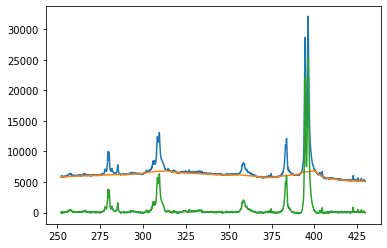

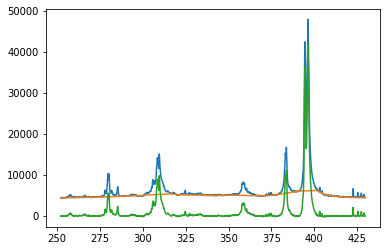

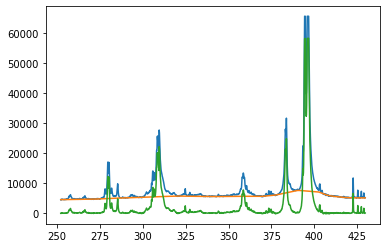

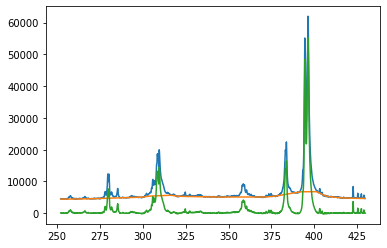

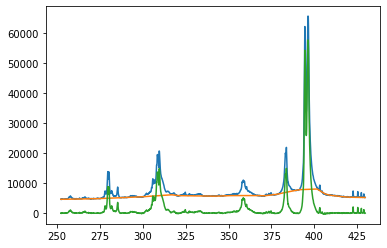

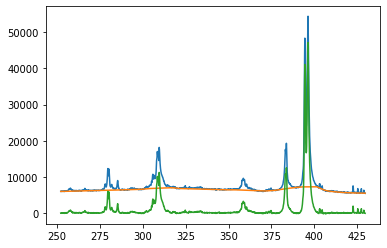

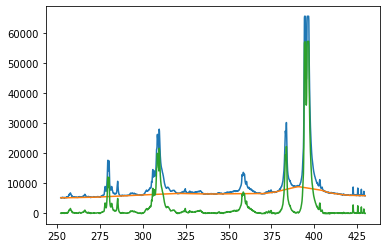

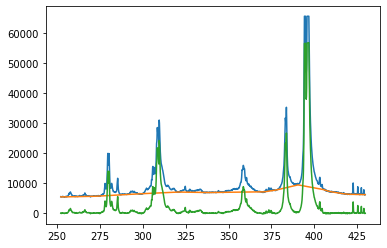

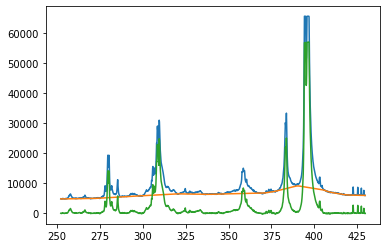

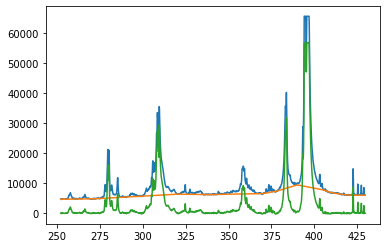

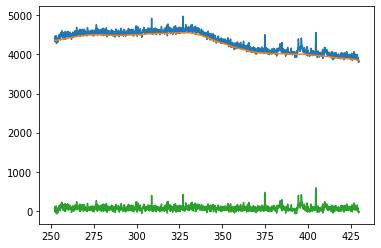

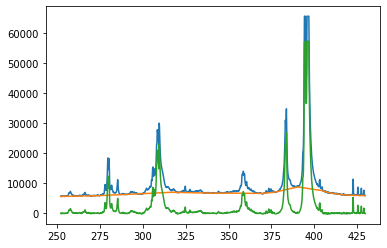

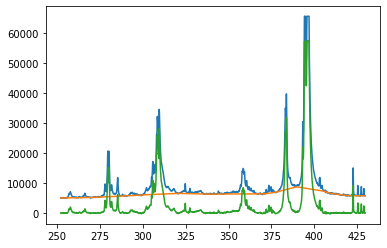

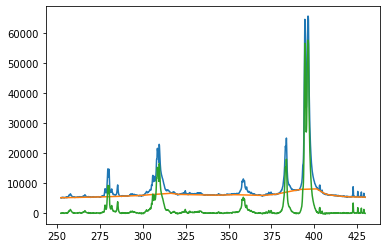

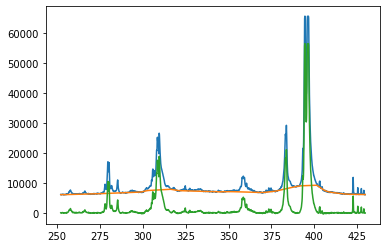

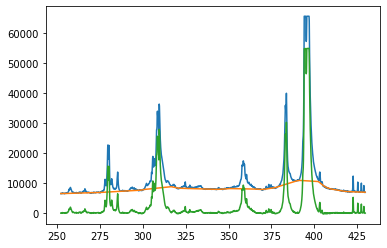

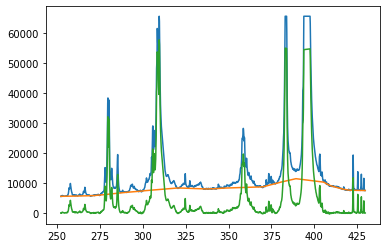

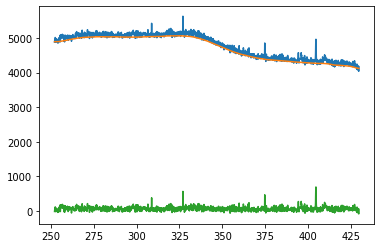

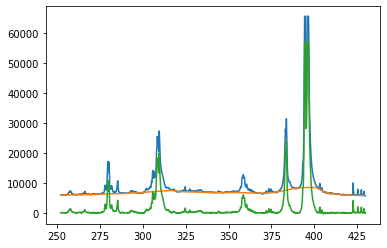

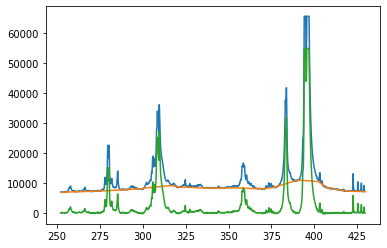

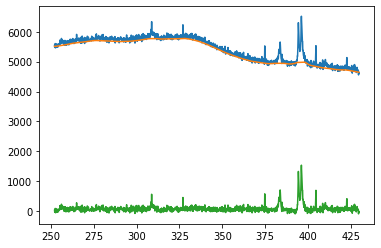

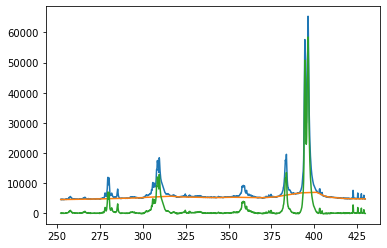

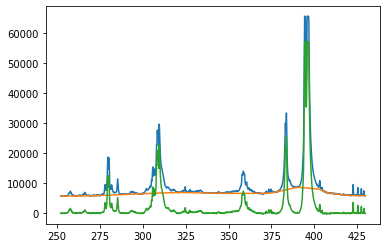

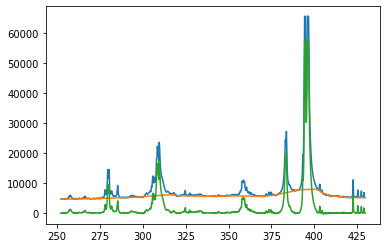

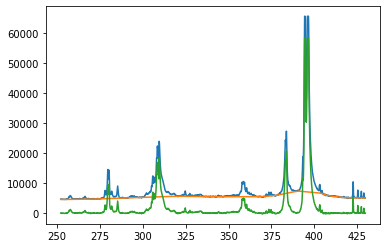

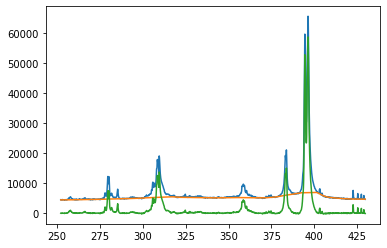

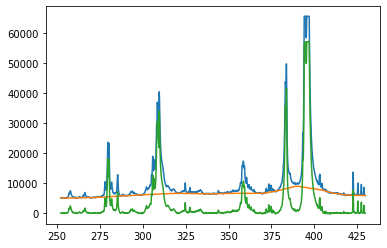

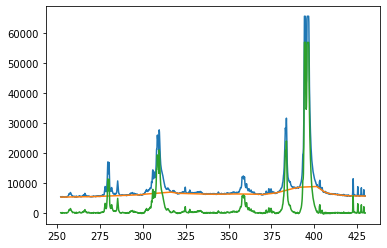

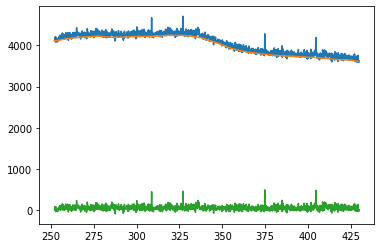

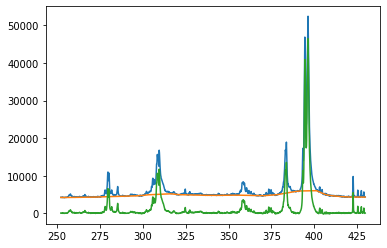

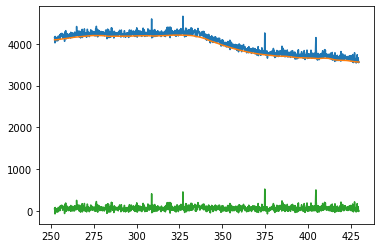

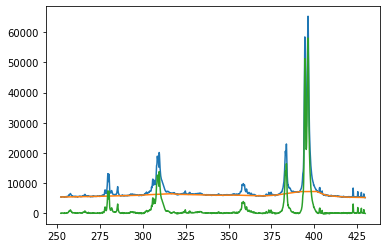

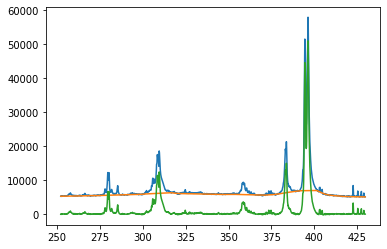

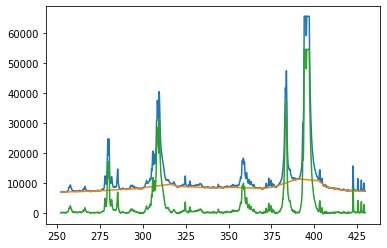

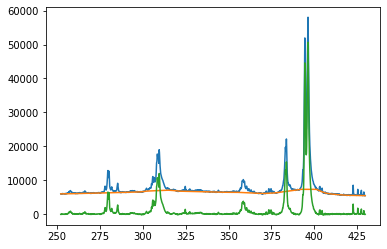

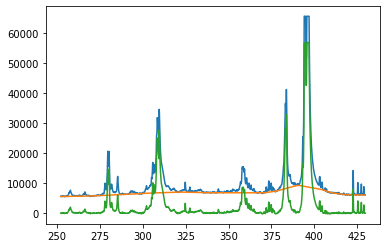

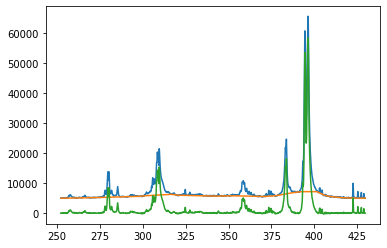

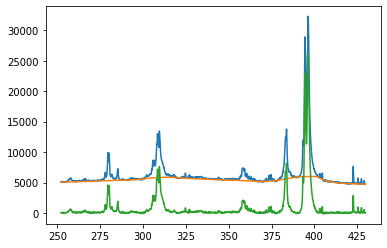

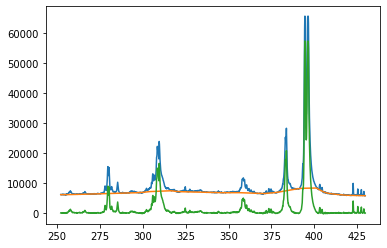

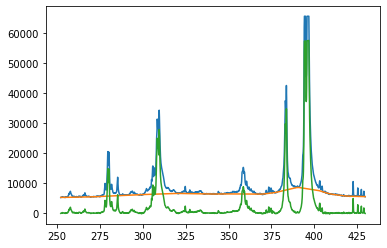

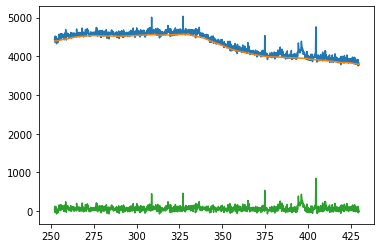

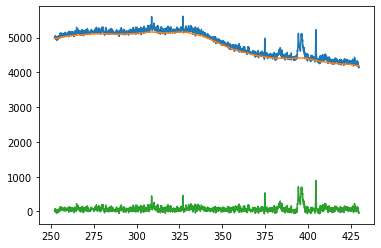

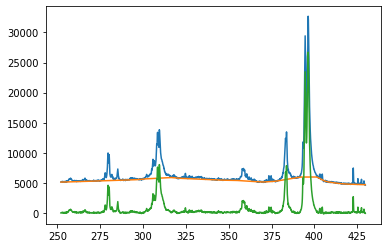

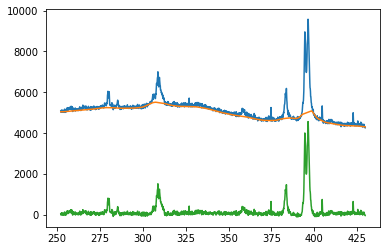

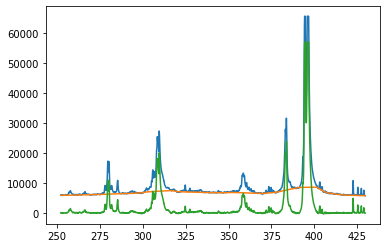

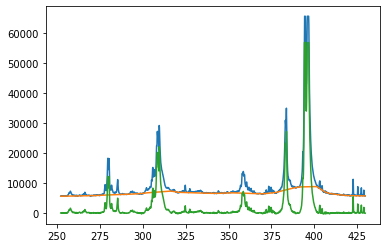

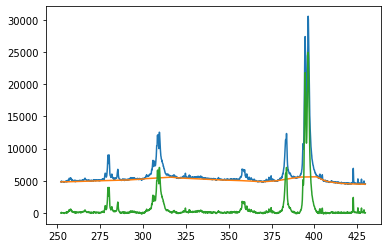

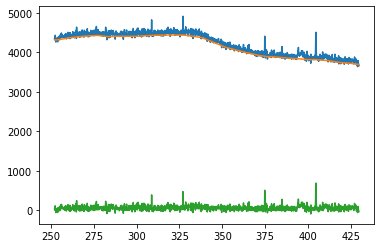

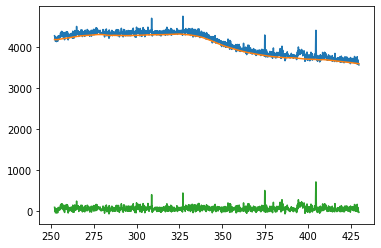

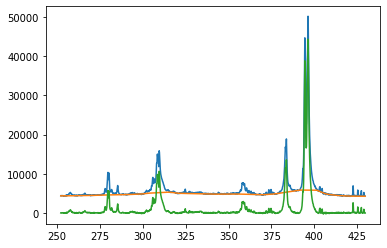

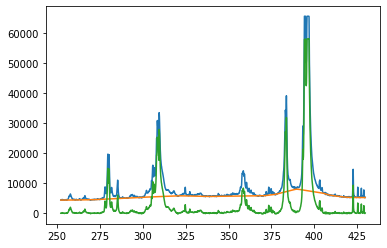

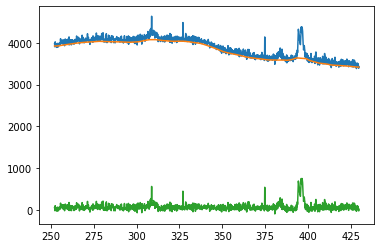

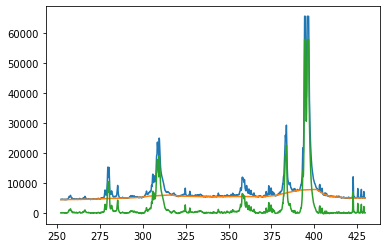

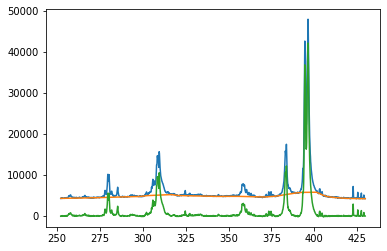

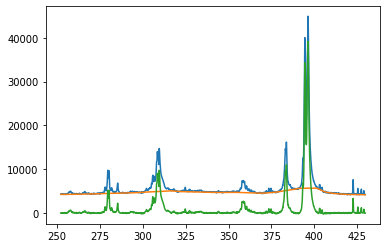

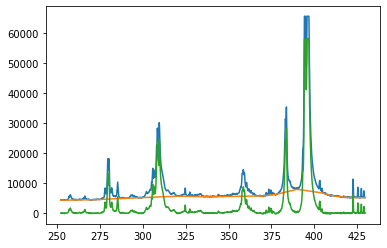

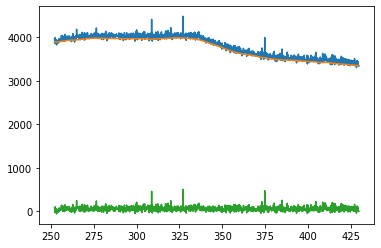

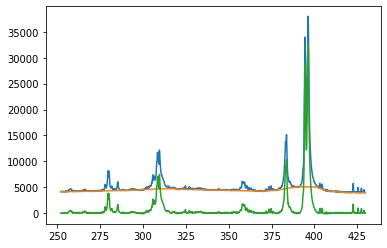

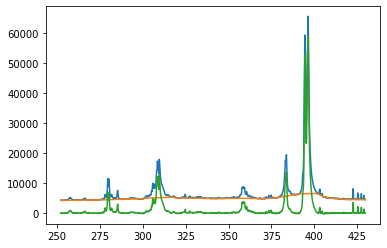

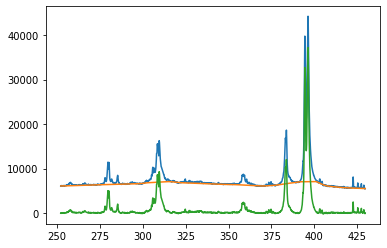

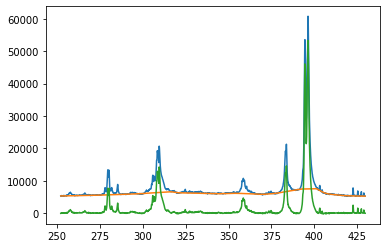

In [28]:
x1= airPLS(data[0,:], lambda_=100, porder=1, itermax=15)

%matplotlib inline
for i in (range(len(data))):
    
    z_i =airPLS(data[i,:], lambda_=100, porder=1, itermax=15)
    
    tmp= data[i,:] - z_i
    #print(max(tmp))
    
    plt.plot(wl, data[i,:])
    plt.plot(wl, z_i)
    plt.plot(wl, tmp)
    plt.show()
    

In [30]:
p=0.001
lam= 10000

tot= np.empty((0, len(wl)))
print(tot.shape)


for j in range(0, len(dfs)): #loop over all .mat files
    data = dfs[j].values
    data = data[1:,:] #this eliminates wavelengths
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl)))

    for i in (range(len(data)) ):
        
        if ((max(data[i,:])) < 65500):
            
            z_i = baseline_als(data[i,:], lam, p, niter=10)

            a = data[i,:] - z_i
            
            if max(a) < 25000:
                count += 1
                
                a= normalize(data[0,:].reshape(1, -1)).T
                #print(i)
                #plt.plot(wl, data[:,i])
                #plt.show()
                tmp = np.append(tmp, a.reshape(1, -1), axis=0)


    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    #avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

(0, 1446)
data index: 0
data 0 shape:  (100, 1446)
good spectra:  27
tmp shape:  (27, 1446)
avg array shape:  (1, 1446)

data index: 1
data 1 shape:  (51, 1446)
good spectra:  36
tmp shape:  (36, 1446)
avg array shape:  (1, 1446)

data index: 2
data 2 shape:  (35, 1446)
good spectra:  6
tmp shape:  (6, 1446)
avg array shape:  (1, 1446)

data index: 3
data 3 shape:  (46, 1446)
good spectra:  21
tmp shape:  (21, 1446)
avg array shape:  (1, 1446)

data index: 4
data 4 shape:  (28, 1446)
good spectra:  4
tmp shape:  (4, 1446)
avg array shape:  (1, 1446)

data index: 5
data 5 shape:  (40, 1446)
good spectra:  2
tmp shape:  (2, 1446)
avg array shape:  (1, 1446)

data index: 6
data 6 shape:  (66, 1446)
good spectra:  60
tmp shape:  (60, 1446)
avg array shape:  (1, 1446)

data index: 7
data 7 shape:  (32, 1446)
good spectra:  12
tmp shape:  (12, 1446)
avg array shape:  (1, 1446)

data index: 8
data 8 shape:  (34, 1446)
good spectra:  7
tmp shape:  (7, 1446)
avg array shape:  (1, 1446)

data in

In [30]:
asd

NameError: name 'asd' is not defined

<IPython.core.display.Javascript object>


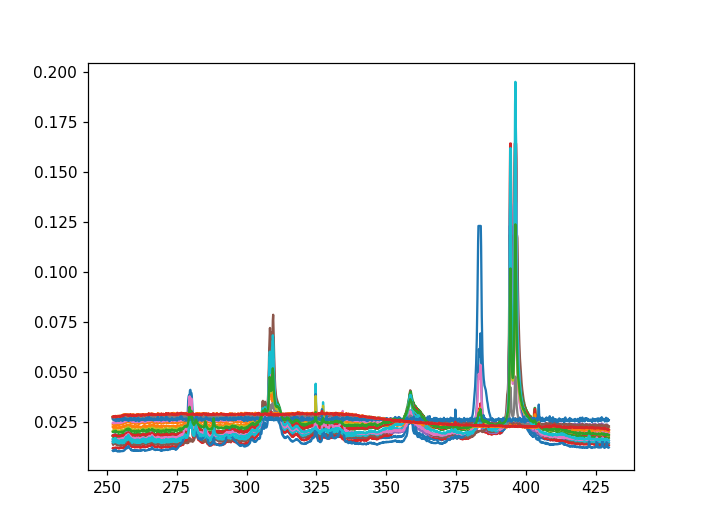

In [31]:
%matplotlib notebook
for i in range(len(tot)):
    plt.plot(wl, tot[i])
    plt.show()

In [41]:
print(wl.shape)
wl= wl.reshape(1,-1)
print(tot.shape)

a= np.append(wl, tot, axis=0)
print(a.shape)
print(a)

#np.savetxt("avg_no_sat_baseline.csv", a, delimiter=",", fmt='%f')

(1446,)
(24, 1446)
(25, 1446)
[[252.0714     252.2017     252.3319     ... 429.491      429.6013
  429.7116    ]
 [167.51423249 190.76024998 167.07315642 ...  83.04988874  83.77356193
  128.99954211]
 [148.27778016 177.92828217  96.32591525 ... 306.53555518 297.83079059
  309.12599509]
 ...
 [117.20802267 115.43103432  32.24460868 ... 181.83595214  95.26816225
  102.64805818]
 [190.35264534 169.93621855 197.51977274 ...  44.92998218  68.0975319
  101.89687801]
 [171.08170943 138.39811605 131.68207577 ... 116.49219342  56.33271932
  111.73766197]]


In [42]:
np.savetxt("avg_no_sat_baseline.csv", a, delimiter=",", fmt='%f')

In [ ]:
tot= np.empty((0, len(wl)))


for j in range(0, len(dfs)):
    data = dfs[j].values
    data = data[1:,:]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl)))

    
    for i in (range(len(data)) ):
    
        z_i = baseline_als(data[i,:], lam, p, niter=10)

        a = data[i,:] - z_i


        if (max(a)) > 25000:

            #a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            #plt.plot(wl, a)
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape) 

In [ ]:
for i in range(len(tot)):
    plt.plot(wl, tot[i])
    #plt.show()

In [ ]:
print(tot.shape)
print(wl.shape)

In [ ]:
print(wl.shape)
wl= wl.reshape(1,-1)
print(tot.shape)

a= np.append(wl, tot, axis=0)
print(a.shape)
print(a)

In [ ]:
#np.savetxt("avg_intesities_baseline_1.csv", a, delimiter=",", fmt='%f')

In [ ]:
X_std = StandardScaler().fit_transform(data)
print(X_std.shape)
X_std

In [ ]:
data_sum= data / np.sum(data,axis=0)
data_sum

In [ ]:
for i in (range(len(X_std[0]))):
    
    plt.plot(wl, X_std[:,i] )
    plt.show()
    

In [ ]:
print(max(data[:,8]))
print(max(data[:,11]))
max(data[:,1])

In [ ]:
count = 0
for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[:,i], lam, p, niter=10)
    
    a = data[:,i] - z_i
    
    #a=  a / np.sum(a,axis=0)
    #a=  a / np.max(a,axis=0)


    count += 1
    #print(i)
    plt.plot(wl, a)
    #plt.show()
print("good spectra: ", count)

In [ ]:
count = 0
for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[600:1730,i], lam, p, niter=10)
    
    a = data[600:1730,i] - z_i
    
    
    if (max(a)) > 25000:
        
        a =  a / np.sum(a,axis=0)
        #a = StandardScaler().fit_transform(a.reshape(-1, 1))
        #a= normalize(a.reshape(-1, 1))
        
        count += 1
        #print(i)
        plt.plot(wl[600:1730], a)
        plt.show()
        #plt.savefig('./graph.png')
print("good spectra: ", count)

In [ ]:
count=0

#result_array = np.empty_like(wl)
tmp = np.empty((0, len(wl)))

for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[:,i], lam, p, niter=10)
    
    if ((max(data[:,i]-z_i)) > 10000) and ((max(data[:,i])) < 65500):
        count += 1
        #print(i)
        plt.plot(wl, data[:,i])
        #plt.show()
        tmp = np.append(tmp, [data[:,i]], axis=0)
        
        
print("good spectra: ", count)
print(tmp.shape)

avg_arr= np.max(tmp, axis=0)
#avg_arr= np.mean(tmp, axis=0)
print(avg_arr.shape)




In [ ]:
count=0

#result_array = np.empty_like(wl)
tmp = np.empty((0, len(wl)))

for i in (range(len(data[0])) ):
    if ((max(data[:,i])) > 10000) and ((max(data[:,i])) < 65500):
        count += 1
        #print(i)
        plt.plot(wl, data[:,i])
        #plt.show()
        result_array = np.append(tmp, [data[:,i]], axis=0)
        
        
print("good spectra: ", count)
print(tmp.shape)

avg_arr= np.mean(tmp, axis=0)
print(avg_arr.shape)



In [ ]:

plt.plot(wl, avg_arr)
plt.show()

In [ ]:

good = np.empty([len(wl)])

good1 = np.empty_like(wl)

print(good.shape)
print(good1.shape)

In [ ]:
print(result_array.shape)
print(result_array)
a=np.mean(result_array, axis=0)
print(a.shape)

In [ ]:
"""from glob import glob

#filenames = glob('./ref/*')
filenames = glob('./ref_1/*')


dfs = [scipy.io.loadmat(f) for f in filenames]
print(type(dfs)) #dfs is a list of mat files 
print(len(dfs)) #dfs is a list of mat files 
"""

In [ ]:
tot= np.empty((0, len(wl)))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl)))

    for i in (range(len(data[0])) ):
        
        
    
        if ((max(data[:,i])) > 10000) and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [data[:,i]], axis=0)


    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    #avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

WITH BASELINE CORRECTION

In [ ]:
tot= np.empty((0, len(wl[600:1730])))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl[600:1730])))

    
    for i in (range(len(data[0])) ):
    
        z_i = baseline_als(data[600:1730,i], lam, p, niter=10)

        a = data[600:1730,i] - z_i


        if (max(a)) > 25000:

            a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            plt.plot(wl[600:1730], a)
            plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

In [ ]:
tot= np.empty((0, len(wl[600:1730])))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl[600:1730])))

    
    for i in (range(len(data[0])) ):
        if (max(data[:,i])) > 25000:
            
            
            z_i = baseline_als(data[600:1730,i], lam, p, niter=10)

            a = data[600:1730,i] - z_i


        

            a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            #plt.plot(wl[600:1730], a)
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

In [ ]:
for i in range(len(tot)):
    plt.plot(wl[600:1730], tot[i])
    #plt.show()

In [ ]:
ded #np.savetxt("avg_intesities.csv", tot, delimiter=",", fmt='%f')

In [ ]:
print(wl.shape)
wl1= wl[600:1730].reshape(1,-1)
print(tot.shape)

a= np.append(wl1, tot, axis=0)
a.shape
a

In [ ]:
#np.savetxt("avg_intesities_baseline_1.csv", a, delimiter=",", fmt='%f')